## Flight Delay Prediction Classifier Using Machine Learning Algorithms

### W261 Final Project
##### Team 11:  
  - Girija Ghali  
  - Poonam Parhar  
  - Surya Dutta  
  - Thomas Hamnet

## Question Formulation

####Introduction

According to the 'Bureau of Transportation Statistics' (BTS), every year approximately 15 to 20 percent flights get delayed. Flight delays cause billions of dollars of losses to airlines each year, and are a great inconvenience to passengers. In order to optimize operations of airlines and airports, and to improve customer satisfaction, several attempts have been made in building flight delay prediction systems. 

**Flight Delay Report From BTS**
  
<img src="https://github.com/poonamparhar/project_images/blob/master/BTS_delay_report.png?raw=true" height=400 width=450>

In this project, we are particularly interested in predicting flight departure delays. A flight departure is considered delayed if it takes off 15 minutes later than its Computerized Reservation System (scheduled) time. Our goal is to build a classifier system capable of predicting whether or not a flight would be delayed two hours ahead of the planned departure time so as to give sufficient heads up time to passengers, and enough time to airlines and airports to replan their operations.

A large number of studies have already been conducted to build Machine Learning Based Models to accurately predict flight delays. For instance: (1) Prediction of weather-induced airline delays based on machine learning algorithms [https://ieeexplore.ieee.org/abstract/document/7777956/] and (2) A Data Mining Approach to Flight Arrival Delay Prediction for American Airlines [https://arxiv.org/ftp/arxiv/papers/1903/1903.06740.pdf]. In research paper (2), the reported Area Under Receiver Operating Curve score is 0.90.

####About the Data

The primary dataset that we will be using is the Airlines dataset. This is a subset of the passenger flight's on-time performance data taken from the TranStats data collection available from the U.S. Department of Transportation (DOT). The description on all of its fields can be found here: https://www.transtats.bts.gov/Fields.asp?table_id=236. The dataset is in the format of parquet files, and there are total 31,746,841 records on flights departing from all major US airports for the Jan 2015 to Dec 2019 timeframe. Some of the important fields pertaining to flights performance in this dataset are: time period of flights, airlines information, origin and destination of flights, arrival and departure performance, and causes of delays. 

The second dataset that we have available for predicting flight delays is the Integrated Surface Dataset (ISD). This dataset has been downloaded from the National Oceanic and Atmospheric Administration repository. We will be calling it the Weather dataset throughout this report. Some noteable features included in this dataset are air quality, atmospheric pressure, atmospheric temperature/dew point, atmospheric winds, clouds, precipitation, ocean waves, tides and more. There are 630,904,436 records in this dataset.

The third dataset that we have available is the weather Stations dataset, containing 29,771 records.

In [3]:
!pip install timezonefinder
!pip install handyspark

import os
import re
import ast
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, ArrayType, FloatType
from pyspark.sql import SQLContext
from pyspark.sql.window import Window

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler, PCA, VectorSlicer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics

from graphframes import *

from timezonefinder import TimezoneFinder
from datetime import datetime, timedelta
from pytz import timezone, utc
from itertools import chain

from handyspark import *
from urllib.request import *
from zipfile import ZipFile
import io

## Prepare Data

### Notebook Configuration

While starting out, we anticipated a number of challenges we would face while working with these datasets and the expensive process of building additional datasets and models that we would eventually use. We decided to spend some time and build up a framework to abstract this complexity away so we could easily save and load our progress at any time, not have to keep track of filepaths and implementation details, and **keep a clean barrier between the three different dateranges** we would be working with in this project. 

Thus, we built a class specifically for this called the `Datasets` class. Each instance of this class refers to a collection of datasets that is specifically tied to either the three month, six month, or full 5 year daterange when initialized. The class contains methods for us to load, retrieve, set, update, filter, and otherwise maniputate our datasets through this process. The main point of leverage for this class is it's logic to build/retrieve filepaths based on the timerange, dataset type, and properties. With this, we could ensure we weren't working with wrong or mismatched datasets.

In [7]:
from enum import Enum

class DatasetRange(Enum):
  THREE_MONTH = 1
  SIX_MONTH = 2
  FULL = 3
  
class DataType(Enum):
  AIRLINES = 1
  WEATHER = 2
  STATION = 3
  CALL_MAPPING = 4
  OFFSET_MAPPING = 5
  JOINED = 6
  PAGERANK = 7

#config
REJOIN = False
TEMP_DATA_FILEPATH = "final_project_team11/dataframes"
TEMP_MODELS_FILEPATH = "/final_project_team11/models"

In [8]:
class Datasets:
  
  datasets = {
    DataType.AIRLINES: None,
    DataType.WEATHER: None,
    DataType.STATION: None,
    DataType.CALL_MAPPING: None,
    DataType.JOINED: None,
    DataType.PAGERANK: None
  }
  
  distinct_calls = None
  distinct_airports = None
   
  def __init__(self, datasetRange, tempFileDir):
    self.datasetRange = datasetRange
    self.datapath = f"dbfs:/mnt/mids-w261/data"
    self.tempFileDir = tempFileDir
  
  #retrieves the dataset if initialized
  def Get(self, DataType):
    data = self.datasets[DataType]
    if not data:
      raise TypeError 
    return data
  
  #sets the dataset with the input data
  def Set(self, DataType, NewData):
    self.datasets[DataType] = NewData
  
  #pass-through caching functionality
  def Cache(self, DataType):
    self.datasets[DataType] = self.datasets[DataType].cache()
    
  #filters out the columns we need, and converts each column to it's correct type
  def FilterColumns(self, datatype, columnsAndType):
    self.datasets[datatype] = self.datasets[datatype].select([c for c in self.datasets[datatype].columns if c in columnsAndType.keys()])
    for key, value in columnsAndType.items():
        self.datasets[datatype] = self.datasets[datatype].withColumn(key, self.datasets[datatype][key].cast(value))
    
  #this method encapsulates the logic to load the starting raw datasets
  def LoadIndividualDatasets(self):

    filePaths = self.GetFilePaths()
    
    self.datasets[DataType.WEATHER] = spark.read\
                                            .option("header", "true")\
                                            .parquet(filePaths[DataType.WEATHER])
    
    self.datasets[DataType.AIRLINES] = spark.read\
                                            .option("header", "true")\
                                            .parquet(filePaths[DataType.AIRLINES])

    self.datasets[DataType.STATION] = spark.read\
                                           .option("header", "true")\
                                           .csv(filePaths[DataType.STATION])  
    
    
    self.distinct_airports = self.datasets[DataType.AIRLINES].select("ORIGIN").distinct().rdd.map(lambda r: r[0]).collect()
    
    #check if file exists
    callMappingFile = self.GetFilePaths(useLocalFilePath=True)[DataType.CALL_MAPPING]
    if not os.path.exists(callMappingFile):
      call_mapping = self.getCallMapping()
      call_mapping.to_pickle(callMappingFile)
      
    else:
      call_mapping = pd.read_pickle(callMappingFile)
      
    self.datasets[DataType.CALL_MAPPING] = call_mapping[call_mapping.index.isin(self.distinct_airports)].to_dict()
    
    self.distinct_calls = list(self.datasets[DataType.CALL_MAPPING].values())
    
  #loads the joined dataset at a specific point in the pipeline
  def LoadJoinedDataset(self, suffix):
            
    if not os.path.exists(self.GetFilePaths(useLocalFilePath=True, suffix=suffix)[DataType.JOINED]):
      raise ValueError

    self.datasets[DataType.JOINED] = spark.read\
                                           .option("header", "true")\
                                           .load(self.GetFilePaths(useLocalFilePath=False, suffix=suffix)[DataType.JOINED])   
    
  #checkpoints the joined dataset at a specific point in the pipeline
  def SaveJoinedDataset(self, joined_data, suffix):
    joinedDataFilepath = self.GetFilePaths(useLocalFilePath=False, suffix=suffix)[DataType.JOINED]
    self.datasets[DataType.JOINED] = joined_data
    joined_data.write.mode('overwrite').save(joinedDataFilepath)
  
  #because the pagerank computation is so expensive, we write out functionality here to only
  #compute it once (for any dataset range), and dynamically retrieve the results after
  def LoadPageRank(self):
    
    page_rank_path = self.GetFilePaths(useLocalFilePath=True)[DataType.PAGERANK]
    
    if os.path.exists(page_rank_path):
      self.datasets[DataType.PAGERANK] = spark.read.load(self.GetFilePaths(useLocalFilePath=False)[DataType.PAGERANK])
      
    else:
      full_data_path = os.path.join(self.datapath, "datasets_final_project/parquet_airlines_data/*.parquet")
      
      airlines_dataset = spark.read\
                              .option("header", "true")\
                              .parquet(full_data_path)
      
      self.datasets[DataType.PAGERANK] = self.computePageranks(airlines_dataset)
      self.datasets[DataType.PAGERANK].write.mode('overwrite').save(page_rank_path)
    
  #core method to derive the specific filepath for all datasets
  def GetFilePaths(self, useLocalFilePath=False, suffix=None):
    
    station_path = os.path.join(self.datapath, "DEMO8/gsod/stations.csv.gz")
    
    localFilePathPrefix = "/dbfs/" if useLocalFilePath else "dbfs:/"
    call_mapping_path = localFilePathPrefix + os.path.join("dbfs", self.tempFileDir, 'airport_call_mapping.pkl')
    joined_dataset_path = localFilePathPrefix + os.path.join(self.tempFileDir, "joined")
    pagerank_path = localFilePathPrefix + os.path.join(self.tempFileDir, "pageranks")

    if (self.datasetRange == DatasetRange.THREE_MONTH):
      weather_path = os.path.join(self.datapath, "datasets_final_project/weather_data/weather2015a.parquet")
      airline_path = os.path.join(self.datapath, "datasets_final_project/parquet_airlines_data_3m/*.parquet")
      joined_path = os.path.join(joined_dataset_path, "3m")

    elif (self.datasetRange == DatasetRange.SIX_MONTH):
      weather_path = os.path.join(self.datapath, "datasets_final_project/weather_data/weather2015a.parquet")
      airline_path = os.path.join(self.datapath, "datasets_final_project/parquet_airlines_data_6m/*.parquet")
      joined_path = os.path.join(joined_dataset_path, "6m")

    elif (self.datasetRange == DatasetRange.FULL):
      weather_path = os.path.join(self.datapath, "datasets_final_project/weather_data/*.parquet")
      airline_path = os.path.join(self.datapath, "datasets_final_project/parquet_airlines_data/*.parquet")
      joined_path = os.path.join(joined_dataset_path, "FULL")

    else:
      raise ValueError
      
    joined_path += "_" + str(suffix) if suffix else ""
      
    return {
      DataType.AIRLINES: airline_path,
      DataType.WEATHER: weather_path,
      DataType.STATION: station_path,
      DataType.CALL_MAPPING: call_mapping_path,
      DataType.JOINED: joined_path,
      DataType.PAGERANK: pagerank_path
    }
  
  #generates the airport code <-> station call mapping via an external data source
  @staticmethod 
  def getCallMapping():
  
    zipFileURL = "https://www.partow.net/downloads/GlobalAirportDatabase.zip"

    resp = urlopen(zipFileURL)
    zipFile = ZipFile(io.BytesIO(resp.read()))
    serializedData = zipFile.open('GlobalAirportDatabase.txt').read()

    records = [record.split(":")[:2] for record in serializedData.decode("utf-8").split("\n")]

    airportDataDF = pd.DataFrame(records, columns=["CALL", "ORIGIN"])
    airportDataDF = airportDataDF[airportDataDF["ORIGIN"]!="N/A"]
    airportDataDF = airportDataDF.set_index('ORIGIN')["CALL"]

    return airportDataDF
  
  #the initial page rank computation - only have to do this once ever!
  @staticmethod 
  def computePageranks(full_airlines_dataset):
        
    v = full_airlines_dataset.select('ORIGIN_AIRPORT_ID').withColumnRenamed('ORIGIN_AIRPORT_ID','id').distinct()

    e = full_airlines_dataset.select('ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID')\
               .withColumnRenamed('ORIGIN_AIRPORT_ID','src')\
               .withColumnRenamed('DEST_AIRPORT_ID','dst')

    g = GraphFrame(v, e)
    results = g.pageRank(resetProbability=0.15, maxIter=10)
    pageranks = results.vertices
    return pageranks

### First look at data - pick interesting variables

In [10]:
data = Datasets(DatasetRange.FULL, TEMP_DATA_FILEPATH)
data.LoadIndividualDatasets()

#### First Look: Airlines Data

In [12]:
print("Airlines Records Count: {}".format(data.Get(DataType.AIRLINES).count()))

Airlines Records Count: 31746841

Based on the schema and the documentation, we pick the following airline dataset variables to use for our model. 
We also take this opportunity to cast these columns into their appropriate type:

In [14]:
AIRLINE_COLUMNS_TO_USE = {
                   "ORIGIN": "string",
         "ORIGIN_CITY_NAME": "string",
        "ORIGIN_AIRPORT_ID": "string",
          "DEST_AIRPORT_ID": "string",
    "OP_CARRIER_AIRLINE_ID": "string",
        "OP_CARRIER_FL_NUM": "string",
                 "TAIL_NUM": "string",
             "DEP_TIME_BLK": "string",
             "ARR_TIME_BLK": "string",
             "CRS_DEP_TIME": "string",
             "CRS_ARR_TIME": "string",
         "CRS_ELAPSED_TIME": "float",
                 "DISTANCE": "double",
           "DISTANCE_GROUP": "int",
                  "QUARTER": "int",
                    "MONTH": "int",
             "DAY_OF_MONTH": "int",
              "DAY_OF_WEEK": "int",
                  "FL_DATE": "string",
                "DEP_DELAY": "float",
                "DEP_DEL15": "int"
}

data.FilterColumns(DataType.AIRLINES, AIRLINE_COLUMNS_TO_USE)

#### First Look: Weather Data

In [16]:
print("Weather Records Count: {}".format(data.Get(DataType.WEATHER).count()))

Weather Records Count: 630904436

In [17]:
display(data.Get(DataType.WEATHER).take(5))

STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP,AW1,GA1,GA2,GA3,GA4,GE1,GF1,KA1,KA2,MA1,MD1,MW1,MW2,OC1,OD1,OD2,REM,EQD,AW2,AX4,GD1,AW5,GN1,AJ1,AW3,MK1,KA4,GG3,AN1,RH1,AU5,HL1,OB1,AT8,AW7,AZ1,CH1,RH3,GK1,IB1,AX1,CT1,AK1,CN2,OE1,MW5,AO1,KA3,AA3,CR1,CF2,KB2,GM1,AT5,AY2,MW6,MG1,AH6,AU2,GD2,AW4,MF1,AA1,AH2,AH3,OE3,AT6,AL2,AL3,AX5,IB2,AI3,CV3,WA1,GH1,KF1,CU2,CT3,SA1,AU1,KD2,AI5,GO1,GD3,CG3,AI1,AL1,AW6,MW4,AX6,CV1,ME1,KC2,CN1,UA1,GD5,UG2,AT3,AT4,GJ1,MV1,GA5,CT2,CG2,ED1,AE1,CO1,KE1,KB1,AI4,MW3,KG2,AA2,AX2,AY1,RH2,OE2,CU3,MH1,AM1,AU4,GA6,KG1,AU3,AT7,KD1,GL1,IA1,GG2,OD3,UG1,CB1,AI6,CI1,CV2,AZ2,AD1,AH1,WD1,AA4,KC1,IA2,CF3,AI2,AT1,GD4,AX3,AH4,KB3,CU1,CN4,AT2,CG1,CF1,GG1,MV2,CW1,GG4,AB1,AH5,CN3
7650099999,2016-01-01T00:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-12,99999,V020,"190,1,N,0015,1","99999,9,9,N","007000,1,9,9","+0101,1","+0090,1","10255,1",,"99,9,+02250,1,99,9",,,,"9,AGL ,+99999,+99999","08,99,1,99,9,99,9,02250,1,99,9,99,9",,,"99999,9,10216,1","8,1,004,1,+999,9","61,1",,,"3,99,0026,1,999",,SYN09807650 04857 81903 10101 20090 30216 40255 58004 69901 761// 333 4/000 69907 90710 91105 555 69905=,,,,,,,"9999,1,9,999999,9,9",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"03,0000,2,1",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"06,0000,2,1",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T00:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"190,1,N,0015,1","22000,1,9,N","009000,1,9,9","+0100,1","+0090,1","99999,9","61,1",,,,,,"00,99,1,99,9,99,9,99999,9,99,9,99,9",,,"10250,1,99999,9",,,,,,,MET057METAR LFML 010000Z AUTO 19003KT 9000 -RA NSC 10/09 Q1025=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T00:30:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"250,1,N,0010,1","99999,9,9,N","008000,1,9,9","+9999,9","+9999,9","99999,9",,,,,,,,,,"10250,1,99999,9",,,,,,,MET056METAR LFML 010030Z AUTO 25002KT 8000 ///TCU 10/09 Q1025=,Q019 2ATOD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T01:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-12,99999,V020,"999,9,C,0000,1","99999,9,9,N","004900,1,9,9","+0099,1","+0094,1","10251,1",,"99,9,+02250,1,99,9",,,,"9,AGL ,+99999,+99999","08,99,1,99,9,99,9,02250,1,99,9,99,9",,,"99999,9,10212,1","8,1,006,1,+999,9","10,1",,,"3,99,0015,1,999",,SYN07607650 24849 80000 10099 20094 30212 40251 58006 710// 333 69925 90710 91103=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"01,0002,3,1",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T01:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"999,9,C,0000,1","22000,1,9,N","007000,1,9,9","+0100,1","+0090,1","99999,9",,,,,,,"00,99,1,99,9,99,9,99999,9,99,9,99,9",,,"10250,1,99999,9",,,,,,,MET053METAR LFML 010100Z AUTO 00000KT 7000 NSC 10/09 Q1025=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Looking at the documentation, we first note that the report types we are interested in are of the type `FM-15`, so we start by filtering out any other reports:

In [19]:
weatherData = data.Get(DataType.WEATHER)
weatherData = weatherData.filter(f.col('REPORT_TYPE')=='FM-15')
data.Set(DataType.WEATHER, weatherData)

display(data.Get(DataType.WEATHER).take(10))

STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP,AW1,GA1,GA2,GA3,GA4,GE1,GF1,KA1,KA2,MA1,MD1,MW1,MW2,OC1,OD1,OD2,REM,EQD,AW2,AX4,GD1,AW5,GN1,AJ1,AW3,MK1,KA4,GG3,AN1,RH1,AU5,HL1,OB1,AT8,AW7,AZ1,CH1,RH3,GK1,IB1,AX1,CT1,AK1,CN2,OE1,MW5,AO1,KA3,AA3,CR1,CF2,KB2,GM1,AT5,AY2,MW6,MG1,AH6,AU2,GD2,AW4,MF1,AA1,AH2,AH3,OE3,AT6,AL2,AL3,AX5,IB2,AI3,CV3,WA1,GH1,KF1,CU2,CT3,SA1,AU1,KD2,AI5,GO1,GD3,CG3,AI1,AL1,AW6,MW4,AX6,CV1,ME1,KC2,CN1,UA1,GD5,UG2,AT3,AT4,GJ1,MV1,GA5,CT2,CG2,ED1,AE1,CO1,KE1,KB1,AI4,MW3,KG2,AA2,AX2,AY1,RH2,OE2,CU3,MH1,AM1,AU4,GA6,KG1,AU3,AT7,KD1,GL1,IA1,GG2,OD3,UG1,CB1,AI6,CI1,CV2,AZ2,AD1,AH1,WD1,AA4,KC1,IA2,CF3,AI2,AT1,GD4,AX3,AH4,KB3,CU1,CN4,AT2,CG1,CF1,GG1,MV2,CW1,GG4,AB1,AH5,CN3
7650099999,2016-01-01T00:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"190,1,N,0015,1","22000,1,9,N","009000,1,9,9","+0100,1","+0090,1","99999,9","61,1",,,,,,"00,99,1,99,9,99,9,99999,9,99,9,99,9",,,"10250,1,99999,9",,,,,,,MET057METAR LFML 010000Z AUTO 19003KT 9000 -RA NSC 10/09 Q1025=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T00:30:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"250,1,N,0010,1","99999,9,9,N","008000,1,9,9","+9999,9","+9999,9","99999,9",,,,,,,,,,"10250,1,99999,9",,,,,,,MET056METAR LFML 010030Z AUTO 25002KT 8000 ///TCU 10/09 Q1025=,Q019 2ATOD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T01:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"999,9,C,0000,1","22000,1,9,N","007000,1,9,9","+0100,1","+0090,1","99999,9",,,,,,,"00,99,1,99,9,99,9,99999,9,99,9,99,9",,,"10250,1,99999,9",,,,,,,MET053METAR LFML 010100Z AUTO 00000KT 7000 NSC 10/09 Q1025=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T01:30:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"999,9,C,0000,1","22000,1,9,N","009000,1,9,9","+0100,1","+0090,1","99999,9",,,,,,,"00,99,1,99,9,99,9,99999,9,99,9,99,9",,,"10250,1,99999,9",,,,,,,MET053METAR LFML 010130Z AUTO 00000KT 9000 NSC 10/09 Q1025=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T02:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"999,9,C,0000,1","99999,9,9,Y","999999,9,9,9","+0100,1","+0090,1","99999,9",,,,,,,,,,"10250,1,99999,9",,,,,,,MET050METAR LFML 010200Z AUTO 00000KT CAVOK 10/09 Q1025=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T02:30:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"320,1,N,0015,1","22000,1,9,N","008000,1,9,9","+0100,1","+0090,1","99999,9",,,,,,,"00,99,1,99,9,99,9,99999,9,99,9,99,9",,,"10250,1,99999,9",,,,,,,MET053METAR LFML 010230Z AUTO 32003KT 8000 NSC 10/09 Q1025=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T03:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"040,1,N,0010,1","22000,1,9,N","006000,1,9,9","+0100,1","+0090,1","99999,9",,,,,,,"00,99,1,99,9,99,9,99999,9,99,9,99,9",,,"10250,1,99999,9",,,,,,,MET054METAR LFML 010300Z 04002KT 6000 NSC 10/09 Q1025 NOSIG=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T03:30:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"999,9,C,0000,1","22000,1,9,N","006000,1,9,9","+010

Next, we take a subset of columns we are interested in, based on the documentation (and the relative sparseness of our first few rows). We will tackle parsing these values and null values in the next section:

In [21]:
WEATHER_COLUMNS_TO_USE = {
    "STATION": "string",
       "DATE": "timestamp",
   "LATITUDE": "double",
  "LONGITUDE": "double",
  "CALL_SIGN": "string",
        "WND": "string",
        "CIG": "string",
        "VIS": "string",
        "TMP": "string",
        "DEW": "string",
        "SLP": "string"
}

data.FilterColumns(DataType.WEATHER, WEATHER_COLUMNS_TO_USE)

###Data Pre-Processing

#### Clean Airlines Data

Let's see how many null values we have:

In [25]:
def getNullCounts(inputDataset):
  nullDF = inputDataset.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in inputDataset.columns])\
                       .toPandas()  
  return nullDF.iloc[0][nullDF.iloc[0]>0].to_dict()

In [26]:
getNullCounts(data.Get(DataType.AIRLINES))

Out[13]: {'TAIL_NUM': 72487,
 'DEP_DELAY': 477296,
 'DEP_DEL15': 477296,
 'CRS_ELAPSED_TIME': 164}

Looks like we have a lot of null values for `DEP_DELAY` and `DEP_DEL15`, which are our main predictor variables. Let's see how many null values remain after exempting these rows:

In [28]:
cleanedData = data.Get(DataType.AIRLINES)
cleanedData = cleanedData.filter(cleanedData.DEP_DEL15.isNotNull())\
                         .filter(cleanedData.DEP_DELAY.isNotNull())

data.Set(DataType.AIRLINES, cleanedData)
getNullCounts(data.Get(DataType.AIRLINES))

Out[14]: {'CRS_ELAPSED_TIME': 31}

Looks good! The only other variable with null values we are interested in for this model is `CRS_ELAPSED_TIME` - let's go ahead and omit the rows that are missing data for that field:

In [30]:
cleanedData = data.Get(DataType.AIRLINES)
cleanedData = cleanedData.filter(cleanedData.CRS_ELAPSED_TIME.isNotNull())

data.Set(DataType.AIRLINES, cleanedData)
getNullCounts(data.Get(DataType.AIRLINES))

Out[15]: {}

We also noticed that the departure time (`CRS_DEP_TIME`) and arrival time (`CRS_ARR_TIME`) were in the format `HHMM`. Since this can misrepresent that data while in numerical form, we convert it into units of minutes:

In [32]:
cleanedData = data.Get(DataType.AIRLINES)
cleanedData = cleanedData.withColumn('CRS_DEP_TIME_MINS', \
                                     (((f.col('CRS_DEP_TIME')/100).cast('int')*60)+\
                                       (f.col('CRS_DEP_TIME')%100)))\
                         .withColumn('CRS_ARR_TIME_MINS', \
                                     (((f.col('CRS_ARR_TIME')/100).cast('int')*60)+\
                                       (f.col('CRS_ARR_TIME')%100)))

data.Set(DataType.AIRLINES, cleanedData)

#### Clean Weather Data

According to the documentation, columns like `WND`, `TMP`, and `VIS` have multiple values embedded in the column. Null values are represented by a series of 9's, and many columns have an embedded quality code, with `3` and `7` labeles as "Erroneous". 

Additionally, we noticed that the call sign variable tends to have trailing whitespace. 

For this task, we would like to filter out all missing and erroneous weather values and trim the whitespace:

In [34]:
def CleanWeatherData(weatherDataset):
  
    weatherDataset = weatherDataset.withColumn("WND_DIR_ANGLE", f.split(f.col('WND'), ',')[0])\
                                   .withColumn("WND_DIR_QUALITY_CODE", f.split(f.col('WND'), ',')[1])\
                                   .withColumn("WND_TYPE_CODE", f.split(f.col('WND'), ',')[2])\
                                   .withColumn("WND_SPEED_RATE", f.split(f.col('WND'), ',')[3])\
                                   .withColumn("WND_SPEED_QUALITY_CODE", f.split(f.col('WND'), ',')[4])\
                                   .withColumn("CIG_HEIGHT_DIM", f.split(f.col('CIG'), ',')[0])\
                                   .withColumn("CIG_QUALITY_CODE", f.split(f.col('CIG'), ',')[1])\
                                   .withColumn("CIG_DET_CODE", f.split(f.col('CIG'), ',')[2])\
                                   .withColumn("CIG_CAVOK_CODE", f.split(f.col('CIG'), ',')[3])\
                                   .withColumn("VIS_DIS_DIM", f.split(f.col('VIS'), ',')[0])\
                                   .withColumn("VIS_DIS_QUALITY_CODE", f.split(f.col('VIS'), ',')[1])\
                                   .withColumn("VIS_VAR_CODE", f.split(f.col('VIS'), ',')[2])\
                                   .withColumn("VIS_QUALITY_VAR_CODE", f.split(f.col('VIS'), ',')[3])\
                                   .withColumn("AIR_TMP", f.split(f.col('TMP'), ',')[0])\
                                   .withColumn("AIR_TMP_QULAITY_CODE", f.split(f.col('TMP'), ',')[1])\
                                   .withColumn("DEW_POINT_TMP", f.split(f.col('DEW'), ',')[0])\
                                   .withColumn("DEW_POINT_QUALITY_CODE", f.split(f.col('DEW'), ',')[1])\
                                   .withColumn("SLP_PSR", f.split(f.col('SLP'), ',')[0])\
                                   .withColumn("SLP_PSR_QUALITY_CODE", f.split(f.col('SLP'), ',')[1])\
                                   .filter(f.col("WND_DIR_ANGLE") != "999")\
                                   .filter((f.col('WND_DIR_QUALITY_CODE') != 3) | (f.col('WND_DIR_QUALITY_CODE') != 7))\
                                   .filter(f.col("WND_SPEED_RATE") != "9999")\
                                   .filter((f.col('WND_SPEED_QUALITY_CODE') != 3) | (f.col('WND_SPEED_QUALITY_CODE') != 7))\
                                   .filter(f.col("CIG_HEIGHT_DIM") != "99999")\
                                   .filter((f.col('CIG_QUALITY_CODE') != 3) | (f.col('CIG_QUALITY_CODE') != 7))\
                                   .filter(f.col("VIS_DIS_DIM") != "999999")\
                                   .filter((f.col('VIS_DIS_QUALITY_CODE') != 3) | (f.col('VIS_DIS_QUALITY_CODE') != 7))\
                                   .filter(f.col("AIR_TMP") != "+9999")\
                                   .filter((f.col('AIR_TMP_QULAITY_CODE') != 3) | (f.col('AIR_TMP_QULAITY_CODE') != 7))\
                                   .filter(f.col("DEW_POINT_TMP") != "+9999")\
                                   .filter((f.col('DEW_POINT_QUALITY_CODE') != 3) | (f.col('DEW_POINT_QUALITY_CODE') != 7))\
                                   .filter(f.col("SLP_PSR") != "99999")\
                                   .filter((f.col('SLP_PSR_QUALITY_CODE') != 3) | (f.col('SLP_PSR_QUALITY_CODE') != 7))\
                                   .withColumn('CALL_SIGN', f.trim(f.col("CALL_SIGN")))
    return weatherDataset

We then again select a subset of columns to base our model off of:

In [36]:
cleanedWeatherData = data.Get(DataType.WEATHER)
cleanedWeatherData = CleanWeatherData(cleanedWeatherData)
data.Set(DataType.WEATHER, cleanedWeatherData)

WEATHER_COLUMNS_TO_USE = {
              "DATE": "timestamp",
           "STATION": "string",
         "CALL_SIGN": "string",
     "WND_DIR_ANGLE": "float",
    "WND_SPEED_RATE": "float",
    "CIG_HEIGHT_DIM": "float",
       "VIS_DIS_DIM": "float",
           "AIR_TMP": "float",
     "DEW_POINT_TMP": "float",
           "SLP_PSR": "float",
}

data.FilterColumns(DataType.WEATHER, WEATHER_COLUMNS_TO_USE)

### Join Data

We start by adding two columns: `AIRLINE ID` and `AIRLINE CALL` to the airline dataset in order to merge correctly with the weather data. The ID is needed to uniquely identify each flight, and the call is needed to merge with the right station:

In [39]:
call_mapping_expr = f.create_map([f.lit(x) for x in chain(*data.Get(DataType.CALL_MAPPING).items())])

airlines_modified = data.Get(DataType.AIRLINES).withColumn("AIRLINE_CALL", call_mapping_expr.getItem(f.col("ORIGIN")))\
                                               .withColumn("AIRLINE_ID", f.concat(\
                                                   f.col("OP_CARRIER_FL_NUM"),\
                                                   f.col("TAIL_NUM"), \
                                                   f.col("FL_DATE"), \
                                                   f.col("CRS_DEP_TIME")))
data.Set(DataType.AIRLINES, airlines_modified)

/databricks/spark/python/pyspark/sql/column.py:308: DeprecationWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
 DeprecationWarning)

We need to calculate the bounds (min date and max date) from the airline data, in order to join the datasets effectively:

In [41]:
airlineDataset = data.Get(DataType.AIRLINES)

airlineDataset =  airlineDataset.withColumn("AIRLINE_TIMESTAMP", f.unix_timestamp(\
                                                          f.to_timestamp(\
                                                              f.concat(\
                                                                  f.col("FL_DATE"), f.lit(" "),\
                                                                  f.lpad(f.col("CRS_DEP_TIME"), 4,'0')\
                                                              ),\
                                                          'yyyy-MM-dd HHmm')))

data.Set(DataType.AIRLINES, airlineDataset)


startDate = datetime.fromtimestamp(\
              data.Get(DataType.AIRLINES).groupby()\
                  .min("AIRLINE_TIMESTAMP")\
                  .collect()[0]["min(AIRLINE_TIMESTAMP)"]) 

endDate = datetime.fromtimestamp(\
              data.Get(DataType.AIRLINES).groupby()\
                  .max("AIRLINE_TIMESTAMP")\
                  .collect()[0]["max(AIRLINE_TIMESTAMP)"]) 

print("Start Date: {}".format(startDate))
print("End Date: {}".format(endDate))

Start Date: 2015-01-01 00:05:00
End Date: 2019-12-31 23:59:00

We will be using the airport code and call sign to merge the airline data to the weather data. However, we will also need to compare timestamps to make sure **we join each flight to the most recent weather reading at least 2 hours before the flight departs**. The first obstacle to overcome is timezones - our airlines data is in local time, while our weather data is in UTC. To solve this, we utilize the stations data, specifically the latitude and longitude of each weather station,

In [43]:
def getOffsetMapping(station_data, distinct_calls, min_date):

  def get_offset(tf, lat, lng):
    """
    returns a location's time zone offset from UTC in minutes.
    """
    try:
        today = datetime.now()
        tz_target = timezone(tf.timezone_at(lng=lng, lat=lat))
        today_target = tz_target.localize(today)
        today_utc = utc.localize(today)
        return (today_utc - today_target).total_seconds() / 60
    except:
        pass

  stations_df = station_data.toPandas()

  stations_df["lat"] = stations_df["lat"].astype('float')
  stations_df["lon"] = stations_df["lon"].astype('float')
  stations_df["end"] = stations_df["end"].astype('int')

  stations_df["station"] = stations_df["usaf"] + stations_df["wban"]

  stations_df = stations_df[
    (stations_df["call"].isin(distinct_calls)) & 
    (stations_df["lat"].notnull()) & 
    (stations_df["lon"].notnull()) & 
    (stations_df["lat"]!=0) & 
    (stations_df["lon"]!=0) &
    (stations_df["end"]>=min_date)
  ]

  tf = TimezoneFinder()

  stations_df["offset"] = stations_df.apply(lambda x: get_offset(tf, x["lat"],x["lon"]), axis=1)

  station_offset_mapping = stations_df[["station","offset"]].set_index("station").to_dict()["offset"]
  
  return station_offset_mapping

offset_mapping = getOffsetMapping(data.Get(DataType.STATION), data.distinct_calls, int(startDate.strftime("%Y%m%d")))

data.Set(DataType.OFFSET_MAPPING, offset_mapping)

The offset mapping is of the format station -> offset (in minutes)

In [45]:
data.Get(DataType.OFFSET_MAPPING)

Out[66]: {'78520300398': -240.0,
 '78520399999': -240.0,
 '78526099999': -240.0,
 '72302099999': -240.0,
 '72518699999': -240.0,
 '72743094850': -240.0,
 '78514011603': -240.0,
 '91765061705': -660.0,
 '70026027502': -480.0,
 '70063727406': -480.0,
 '70133026616': -480.0,
 '70219026615': -480.0,
 '70261026411': -480.0,
 '70273026451': -480.0,
 '70296026410': -480.0,
 '70321025513': -480.0,
 '70326025503': -480.0,
 '70350025501': -480.0,
 '70361025339': -480.0,
 '70371025333': -480.0,
 '70381025309': -480.0,
 '70395025325': -480.0,
 '70454025704': -540.0,
 '72201012836': -240.0,
 '72202012839': -240.0,
 '72203012844': -240.0,
 '72205012815': -240.0,
 '72208013880': -240.0,
 '72210812894': -240.0,
 '72211012842': -240.0,
 '72211612873': -240.0,
 '72214093805': -240.0,
 '72218003820': -240.0,
 '72219013874': -240.0,
 '72221013858': -300.0,
 '72222313899': -300.0,
 '72223013894': -300.0,
 '72223513838': -300.0,
 '72226813839': -300.0,
 '72228013876': -300.0,
 '72231012916': -300.0,
 '72232013970': -300.0,
 '72235003940': -300.0,
 '72240003937': -300.0,
 '72240513976': -300.0,
 '72241012917': -300.0,
 '72243012960': -300.0,
 '72243612906': -300.0,
 '72244012918': -300.0,
 '72244813972': -300.0,
 '72247003901': -300.0,
 '72248013957': -300.0,
 '72248613942': -300.0,
 '72250512904': -300.0,
 '72250612959': -300.0,
 '72251012924': -300.0,
 '72253012921': -300.0,
 '72254013904': -300.0,
 '72256013959': -300.0,
 '72257603902': -300.0,
 '72258013960': -300.0,
 '72259003927': -300.0,
 '72261022010': -300.0,
 '72263023034': -300.0,
 '72265023023': -300.0,
 '72266013962': -300.0,
 '72267023042': -300.0,
 '72268893034': -360.0,
 '72270023044': -360.0,
 '72274023160': -420.0,
 '72278023183': -420.0,
 '72286893138': -420.0,
 '72288023152': -420.0,
 '72290023188': -420.0,
 '72295023174': -420.0,
 '72297023129': -420.0,
 '72297793184': -420.0,
 '72306013722': -240.0,
 '72310013883': -240.0,
 '72314013881': -240.0,
 '72324013882': -240.0,
 '72326013891': -240.0,
 '72327013897': -300.0,
 '72334013893': -300.0,
 '72340313963': -300.0,
 '72341813977': -300.0,
 '72344013964': -300.0,
 '72351013966': -300.0,
 '72353013967': -300.0,
 '72356013968': -300.0,
 '72365623049': -360.0,
 '72372323184': -420.0,
 '72384023155': -420.0,
 '72386023169': -420.0,
 '72389093193': -420.0,
 '72428513812': -240.0,
 '72433813802': -300.0,
 '72434013994': -300.0,
 '72438093819': -240.0,
 '72445003945': -300.0,
 '72446003947': -300.0,
 '72450003928': -300.0,
 '72451523064': -300.0,
 '72464093058': -360.0,
 '72488023185': -420.0,
 '72492023237': -420.0,
 '72493023230': -420.0,
 '72494023234': -420.0,
 '72494523293': -420.0,
 '72530094846': -300.0,
 '72534014819': -300.0,
 '72537094847': -240.0,
 '72539014836': -240.0,
 '72546014933': -300.0,
 '72550014942': -300.0,
 '72551014939': -300.0,
 '72557014943': -300.0,
 '72564024018': -360.0,
 '72565003017': -360.0,
 '72569024089': -360.0,
 '72572024127': -360.0,
 '72581024193': -360.0,
 '72640014839': -300.0,
 '72641014837': -300.0,
 '72645014898': -300.0,
 '72658014922': -300.0,
 '72681024131': -360.0,
 '72698024229': -420.0,
 '72745014913': -300.0,
 '72745594931': -300.0,
 '72747014918': -300.0,
 '72757014916': -300.0,
 '72767094014': -300.0,
 '72772024144': -360.0,
 '72775024143': -360.0,
 '72785024157': -420.0,
 '72793024233': -420.0,
 '72793724222': -420.0,
 '72797624217': -420.0,
 '74704003102': -420.0,
 '74746003904': -300.0,
 '74754093915': -300.0,
 '74783012849': -240.0,
 '74791013717': -240.0,
 '78526011641': -240.0,
 '78543011640': -240.0,
 '78551011624': -240.0,
 '91165022536': -600.0,
 '91182022521': -600.0,
 '91190022516': -600.0,
 '91197521510': -600.0,
 '91212041415': 600.0,
 '91232041418': 600.0,
 '91285021504': -600.0,
 '70200026617': -480.0,
 '72483993225': -420.0,
 '72204012838': -240.0,
 '72206013889': -240.0,
 '72207003822': -240.0,
 '72250012919': -300.0,
 '72252012907': -300.0,
 '72268023009': -360.0,
 '72302013748': -240.0,
 '72308013737': -240.0,
 '72308693741': -240.0,
 '72309593719': -240.0,
 '7231061

We now use this offset to convert the weather data to local time, and filter based on the bounds of the airline data above

In [47]:
offset_mapping_expr = f.create_map([f.lit(x) for x in chain(*data.Get(DataType.OFFSET_MAPPING).items())])

weather_modified = data.Get(DataType.WEATHER).withColumn("WEATHER_TIMESTAMP", \
                                                f.unix_timestamp(f.col("DATE")) + \
                                                offset_mapping_expr.getItem(f.col("STATION")))\
                                             .filter(f.col("WEATHER_TIMESTAMP")>=int((startDate-timedelta(hours=4)).strftime('%s')))\
                                             .filter(f.col("WEATHER_TIMESTAMP")<=int((endDate.strftime('%s'))))

data.Set(DataType.WEATHER, weather_modified)

We now do a couple of steps to make the join more efficient. First, we remove any weather data that will not be used in the join by filtering by the distinct airport calls in the call mapping, as well as the distinct stations the in offset mapping:

In [49]:
#precalculated
valid_calls = sc.broadcast(data.distinct_calls)
valid_stations = sc.broadcast(list(data.Get(DataType.OFFSET_MAPPING).keys()))

filteredWeatherData = data.Get(DataType.WEATHER).filter(f.col("STATION").isin(valid_stations.value))\
                                                .filter(f.col("CALL_SIGN").isin(valid_calls.value))

data.Set(DataType.WEATHER, filteredWeatherData)

Next, we implement a performance hack - we round the weather timestamps and the airline timestamps to the nearest hour. Essentially, this ensures that if both datasets have the same rounded hour value, they are at most one hour apart from each other (-30, +30 mins). This becomes more interesting if we add hours to the weather variable - if we add two hours, the real time difference between rows that have the same rounded value are between +1.5 and +2.5 hours. If we add three hours, the real difference is between +2.5 and +3.5 hours. Therefore, if we generate this feature, we can do two exact joins on this feature, union them together, then use the real time difference and window functions (more expensive operations) to carry us the rest of the way:

In [51]:
newAirlineData = data.Get(DataType.AIRLINES).withColumn("AIRLINE_HOUR", \
                                            (f.round(f.col("AIRLINE_TIMESTAMP")/3600)))

data.Set(DataType.AIRLINES, newAirlineData)


newWeatherData = data.Get(DataType.WEATHER).withColumn("WEATHER_HOUR_PLUS2", \
                                            (f.round(f.col("WEATHER_TIMESTAMP")/3600)+2))\
                                           .withColumn("WEATHER_HOUR_PLUS3", \
                                            (f.round(f.col("WEATHER_TIMESTAMP")/3600)+3))

data.Set(DataType.WEATHER, newWeatherData)

Finally, we're ready to join the data together! We join twice with the hour field, take the union, filter by time difference to ensure the gap of 2 hours, then use a window function to take the most recent weather reading from the station:

In [53]:
airlinesJoinData = data.Get(DataType.AIRLINES)
weatherJoinData = data.Get(DataType.WEATHER)

joined_data1 = airlinesJoinData.join(weatherJoinData, (weatherJoinData.CALL_SIGN==airlinesJoinData.AIRLINE_CALL) & \
                                      (weatherJoinData.WEATHER_HOUR_PLUS2==airlinesJoinData.AIRLINE_HOUR), "inner")

joined_data2 = airlinesJoinData.join(weatherJoinData, (weatherJoinData.CALL_SIGN==airlinesJoinData.AIRLINE_CALL) & \
                                      (weatherJoinData.WEATHER_HOUR_PLUS3==airlinesJoinData.AIRLINE_HOUR), "inner")

joined_data = joined_data1.union(joined_data2)\
                          .withColumn("TIME_DIFF", f.col('AIRLINE_TIMESTAMP') - f.col("WEATHER_TIMESTAMP"))\
                          .filter(f.col("TIME_DIFF")>=(2*3600))\
                          .withColumn("DIFF_RANK",\
                                      f.row_number()\
                                       .over(Window.partitionBy("AIRLINE_ID","CALL_SIGN")\
                                                   .orderBy("TIME_DIFF")))\
                          .filter(f.col("DIFF_RANK") == 1)

data.SaveJoinedDataset(joined_data, "original")

## EDA & Discussion of Challenges

Our prediction goal is to predict whether a given flight departure would be on-time or delayed by 15 minutes or more. Toward this goal, we will be using the variable **DEP_DEL15**.

We will use the 6 months joined dataset to perform the EDA and algorithms exploration. For the final model implementation, we will use the full dataset.

In [57]:
# convert 6 months joined dataset to pandas for visualization
data_6m = Datasets(DatasetRange.SIX_MONTH, TEMP_DATA_FILEPATH)
data_6m.LoadJoinedDataset("original")
dataSample = data_6m.Get(DataType.JOINED).toPandas() 

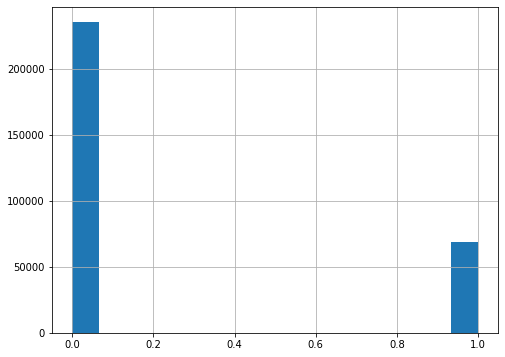

In [58]:
dataSample["DEP_DEL15"].hist(figsize=(8,6), bins=15)

In [59]:
print('% of flights delayed records: {}'.format(len(dataSample[dataSample["DEP_DEL15"] == 1])/len(dataSample)))
print('% of flights not delayed records: {}'.format(len(dataSample[dataSample["DEP_DEL15"] == 0])/len(dataSample)))

% of flights delayed records: 0.22649488397768272
% of flights not delayed records: 0.7735051160223173

As we can see from the histogram and the output above, the number of records for non-delayed flights is much more than the delayed flights records. This clearly shows an imbalance in the number of records for both the classes of our outcome variable.

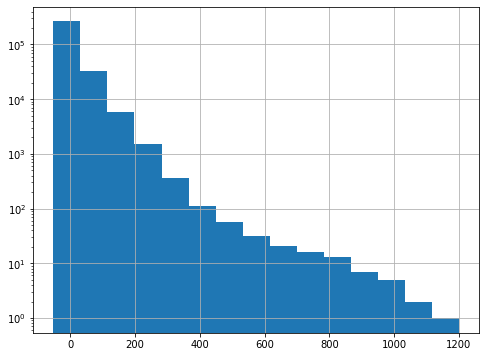

In [61]:
dataSample["DEP_DELAY"].hist(figsize=(8,6), bins=15)
plt.yscale("log")

The distribution of actual delay times follows an inverse power law distribution

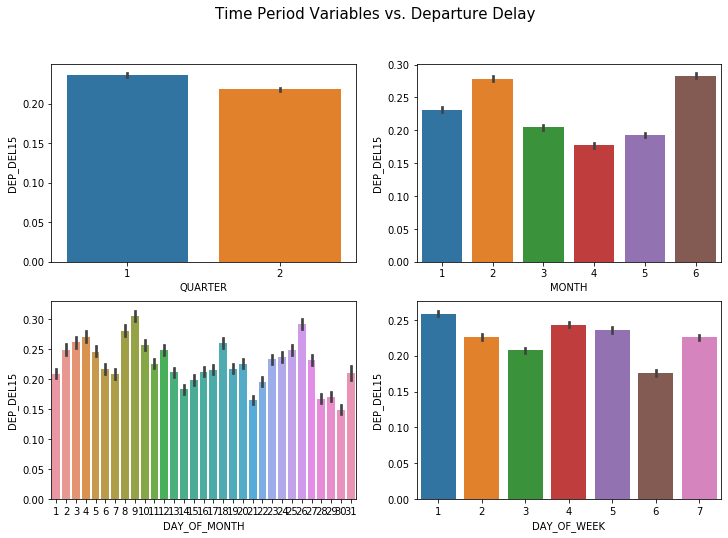

In [63]:
y = 'DEP_DEL15'
feature_cols = ["QUARTER", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK"]

fig, ax_grid = plt.subplots(2, 2, figsize=(12,8))
for idx, feature in enumerate(feature_cols):
    sns.barplot(feature, y, data=dataSample, ax=ax_grid[idx//2][idx%2])
fig.suptitle("Time Period Variables vs. Departure Delay", fontsize=15)
display(plt.show())

The time period variables correlate to the departure delay variable, and will help us in our model.

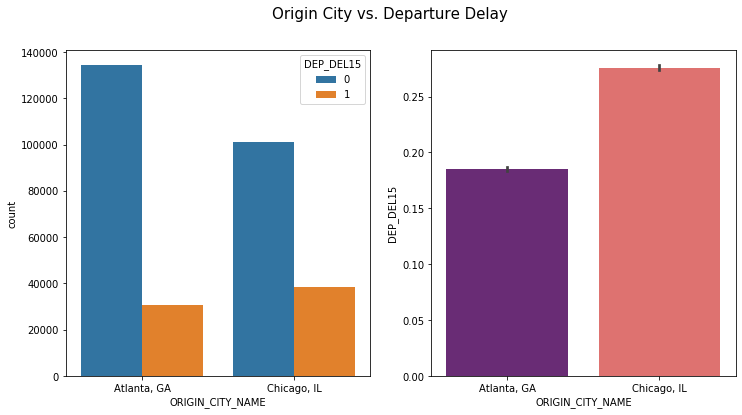

In [65]:
feature = "ORIGIN_CITY_NAME"
fig, ax_grid = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(feature, hue=y, data=dataSample, ax=ax_grid[0])
sns.barplot(feature, y, data=dataSample, ax=ax_grid[1], palette = 'magma')

fig.suptitle("Origin City vs. Departure Delay", fontsize=15)
display(plt.show())

The above plots indicate that the departure delays are related to the origin airports as well.

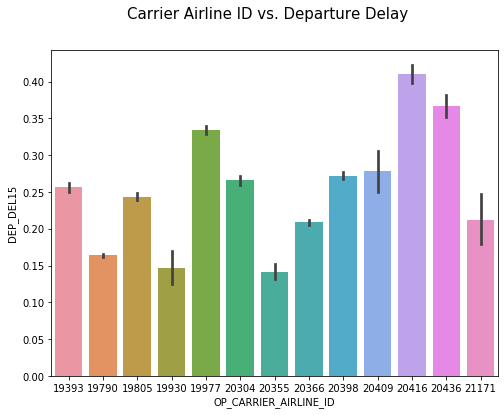

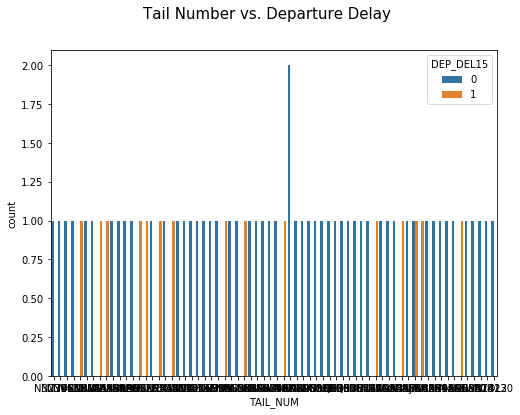

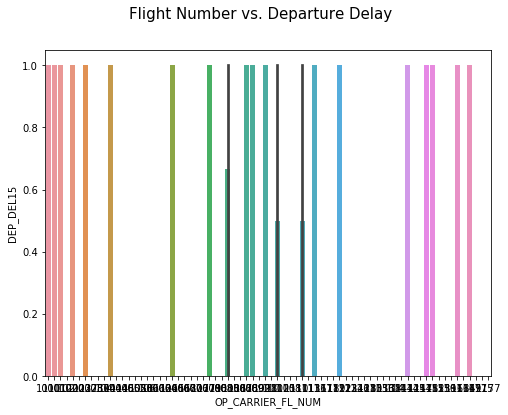

In [67]:
feature = 'OP_CARRIER_AIRLINE_ID'
fig, ax_grid = plt.subplots(figsize=(8,6))
sns.barplot(feature, y, data=dataSample)
fig.suptitle("Carrier Airline ID vs. Departure Delay", fontsize=15)
display(plt.show())

feature = 'TAIL_NUM'          
fig, ax_grid = plt.subplots(figsize=(8,6))
sns.countplot(feature, hue=y, data=dataSample[30:100])
fig.suptitle("Tail Number vs. Departure Delay", fontsize=15)
display(plt.show())

feature = 'OP_CARRIER_FL_NUM'          
fig, ax_grid = plt.subplots(figsize=(8,6))
sns.barplot(feature, y, data=dataSample[:100])
fig.suptitle("Flight Number vs. Departure Delay", fontsize=15)
display(plt.show())

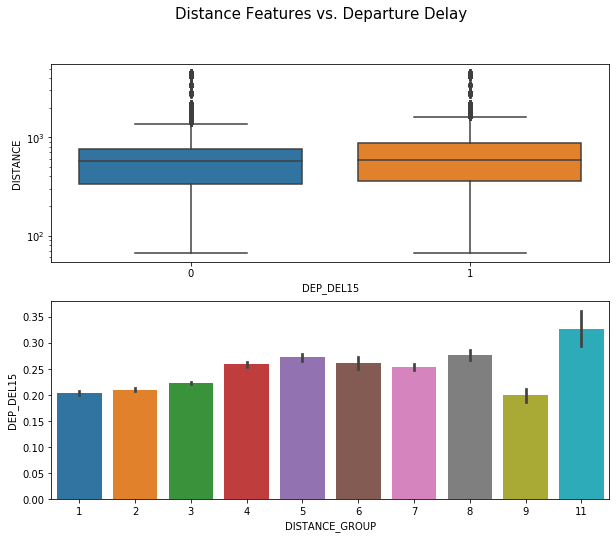

In [68]:
fig, ax_grid = plt.subplots(2, figsize=(10,8))
g = sns.boxplot('DEP_DEL15', 'DISTANCE', data=dataSample, ax=ax_grid[0])
g.set_yscale('log')
sns.barplot('DISTANCE_GROUP', y, data=dataSample, ax=ax_grid[1])
fig.suptitle("Distance Features vs. Departure Delay", fontsize=15)
display(plt.show())

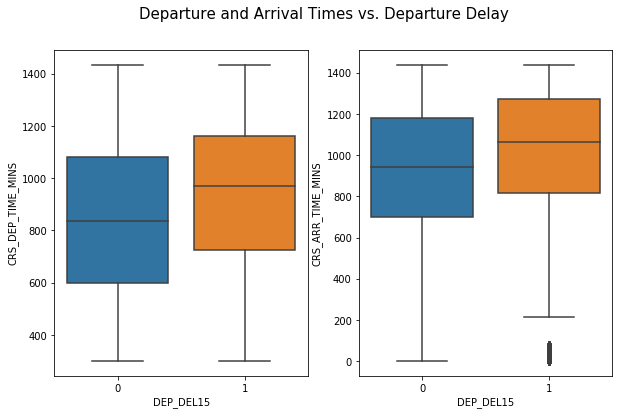

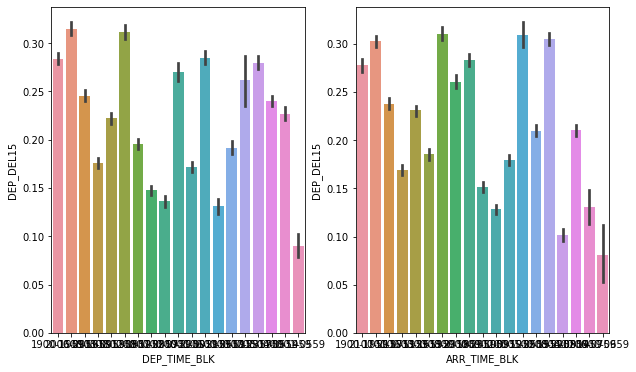

In [69]:
feature_cols = ["CRS_DEP_TIME_MINS", "CRS_ARR_TIME_MINS"]
fig, ax_grid = plt.subplots(1,2, figsize=(10,6))
for idx, feature in enumerate(feature_cols):
    sns.boxplot(y, feature, data=dataSample, ax=ax_grid[idx])
fig.suptitle("Departure and Arrival Times vs. Departure Delay", fontsize=15)
display(plt.show())

feature_cols = ["DEP_TIME_BLK", "ARR_TIME_BLK"]
fig, ax_grid = plt.subplots(1, 2, figsize=(10,6))
for idx, feature in enumerate(feature_cols):
    sns.barplot(feature, y, data=dataSample, ax=ax_grid[idx])    
display(plt.show())

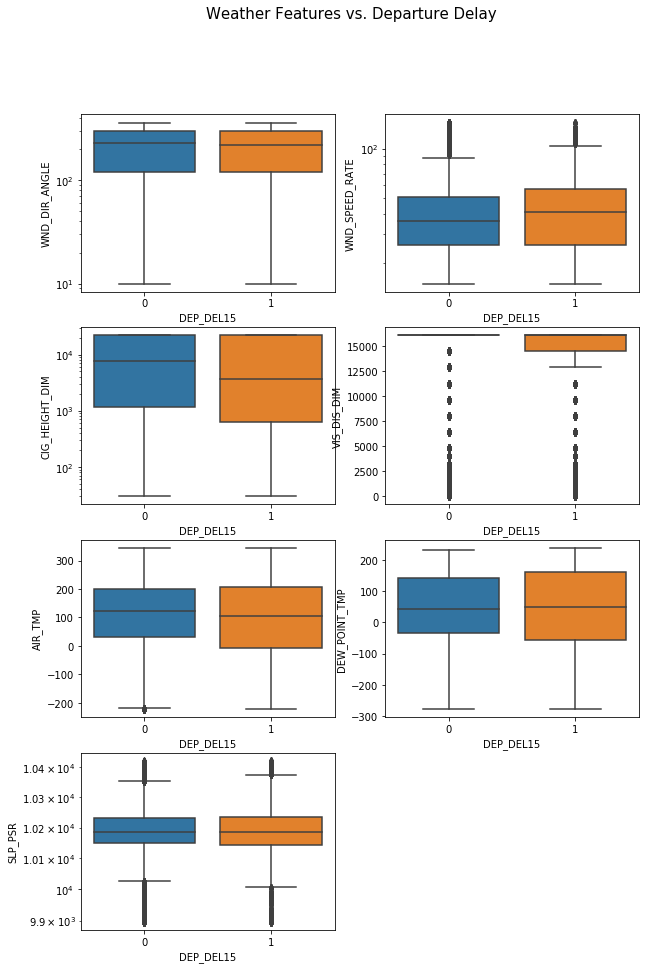

In [70]:
y = 'DEP_DEL15'
weather_feature_cols = ['WND_DIR_ANGLE', 'WND_SPEED_RATE', 'CIG_HEIGHT_DIM', 'VIS_DIS_DIM', 'AIR_TMP', 'DEW_POINT_TMP', 'SLP_PSR']
fig, ax_grid = plt.subplots(4,2, figsize=(10,15))
for idx, feature in enumerate(weather_feature_cols):
    g = sns.boxplot('DEP_DEL15', feature, data=dataSample, ax=ax_grid[idx//2][idx%2])
    if ((feature != 'AIR_TMP') & (feature != 'DEW_POINT_TMP') & (feature != 'VIS_DIS_DIM')):
        g.set_yscale("log")
fig.suptitle("Weather Features vs. Departure Delay", fontsize=15)
fig.delaxes(ax_grid[3,1])
display(plt.show())

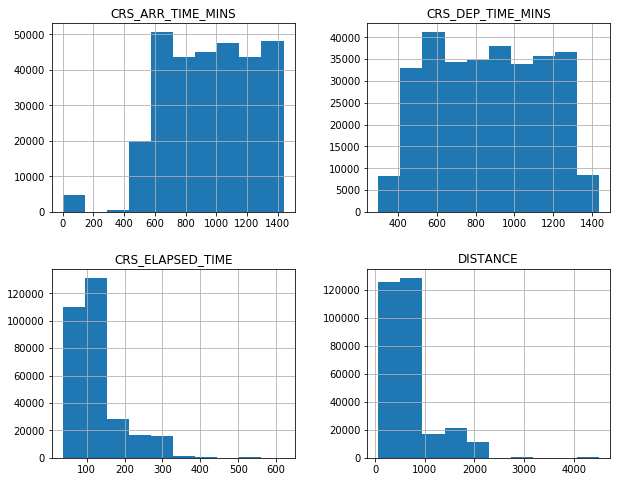

In [71]:
airline_cont_variables = ["DISTANCE", "CRS_ELAPSED_TIME", "CRS_DEP_TIME_MINS", "CRS_ARR_TIME_MINS"]
dataSample.hist(column=airline_cont_variables, figsize=(10,8))

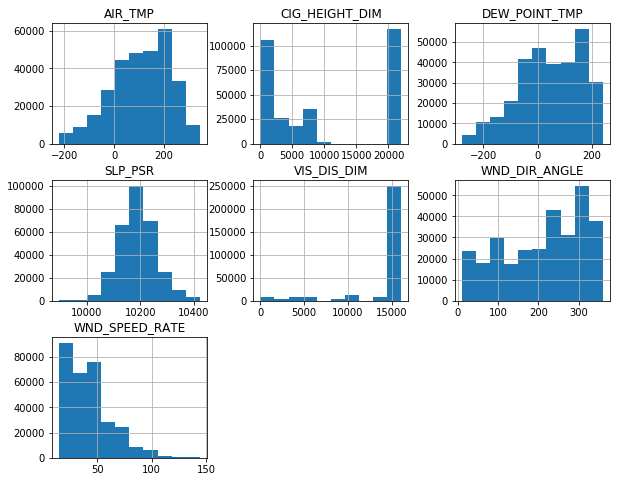

In [72]:
weather_feature_cols = ['WND_DIR_ANGLE', 'WND_SPEED_RATE', 'CIG_HEIGHT_DIM', 'VIS_DIS_DIM', 'AIR_TMP', 'DEW_POINT_TMP', 'SLP_PSR']
dataSample.hist(column=weather_feature_cols, figsize=(10,8))

All the above plots clearly show the distribution of the variables plotted, and their variation with respect to the response variable DEP_DEL15. We will be considering all these variables as potential features for our models. 

Next, we look at the categorical variables.

In [74]:
# Look at categorical variables
categoricals = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'OP_CARRIER_AIRLINE_ID', 'TAIL_NUM', 'OP_CARRIER_FL_NUM']

data.Get(DataType.AIRLINES).agg(*(f.countDistinct(f.col(c)).alias(c) for c in categoricals)).show()
data.Get(DataType.AIRLINES).describe(categoricals).filter( (f.col('summary') == 'max') | (f.col('summary') == 'min') ).show()

+-----------------+---------------+---------------------+--------+-----------------+
ORIGIN_AIRPORT_ID|DEST_AIRPORT_ID|OP_CARRIER_AIRLINE_ID|TAIL_NUM|OP_CARRIER_FL_NUM|
+-----------------+---------------+---------------------+--------+-----------------+
 371| 369| 19| 7894| 7178|
+-----------------+---------------+---------------------+--------+-----------------+

+-------+-----------------+---------------+---------------------+--------+-----------------+
summary|ORIGIN_AIRPORT_ID|DEST_AIRPORT_ID|OP_CARRIER_AIRLINE_ID|TAIL_NUM|OP_CARRIER_FL_NUM|
+-------+-----------------+---------------+---------------------+--------+-----------------+
 min| 10135| 10135| 19393| 215NV| 1|
 max| 16869| 16869| 21171| SS25| 9855|
+-------+-----------------+---------------+---------------------+--------+-----------------+

The above output shows that TAIL_NUM and OP_CARRIER_NUM categorical variables have a large number of values. We will have to perform some feature engineering steps in order to reduce the number of levels for these two variables.

Next, we look at the correlation among all the numerical variables.

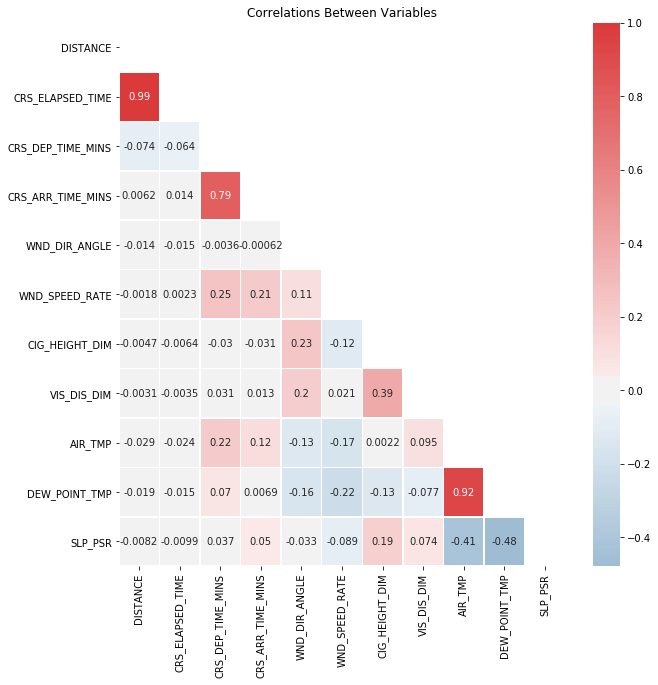

In [77]:
variables_interest = ["ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID", "OP_CARRIER_AIRLINE_ID", "DISTANCE", \
                      "CRS_ELAPSED_TIME", "CRS_DEP_TIME_MINS", "CRS_ARR_TIME_MINS", \
                      'WND_DIR_ANGLE', 'WND_SPEED_RATE', 'CIG_HEIGHT_DIM', 'VIS_DIS_DIM', 'AIR_TMP', \
                      'DEW_POINT_TMP', 'SLP_PSR']
proposed_features = dataSample[variables_interest]
corr = proposed_features.corr()
fig, ax = plt.subplots(figsize=(10,10))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 12, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, annot=True)
plt.title("Correlations Between Variables")
display(plt.show())

From the above plot, it is evident that AIR_TMP and DEW_POINT_TMP are correlated, and CRS_ELAPSED_TIME and CRS_DISTANCE also show strong correlation. We can also note that CRS_ARR_TIME and CRS_DEP_TIME are correlated too.

There are three **main challenges that we see from the EDA**:
  1. The airlines dataset has class imbalance. The number of records for non-delayed flights are approximately four times as compared to the number of delayed flight records. We plan to circumvent this issue by using Random Oversampling Technique.
  2. TAIL_NUM and OP_CARRIER_FL_NUM categorical variables have a large number of values, and these could explode into a huge number of features when String Indexed or One-Hot-Encoded. We will try to combine the low frequency levels of these variables.
  3. As noted in the above plot, the third challenge would be to deal with the multicollinear variables. We plan to use Features Selection techniques in order to drop out one of the correlated variables.

## Feature Engineering

We propose a few new engineered features to tackle the challenges mentioned in the previous section:

In [82]:
data = Datasets(DatasetRange.FULL, TEMP_DATA_FILEPATH)
data.LoadJoinedDataset("original")

####1. Reduce Categorical Levels

In this first feature engineering step, we aim to combine the low frequency values of OP_CARRIER_FL_NUM and TAIL_NUM into a single value. First, we compute the frequency of all the levels of these categorical variables, and then assign the same level for values that occur less than 80th percentile cut-off

In [85]:
joined_data = data.Get(DataType.JOINED)

In [86]:
def reduce_categorical_levels(dataset, prob=0.80):  

    ########## reduce levels of OP_CARRIER_FL_NUM ###############
    
    # Add a new column OP_CARRIER_FL_NUM_MOD with "99999" value for low frequency OP_CARRIER_FL_NUMs
    fl_num_freq = dataset.select(['OP_CARRIER_FL_NUM'])\
                 .groupBy('OP_CARRIER_FL_NUM').agg(f.count('OP_CARRIER_FL_NUM').alias('OP_CARRIER_FL_NUM_Freq'))\
                 .sort(f.desc('OP_CARRIER_FL_NUM_Freq'))

    # get the prob percentile fl_num frequency
    fl_num_low_frequency = fl_num_freq.approxQuantile('OP_CARRIER_FL_NUM_Freq', probabilities=[prob], relativeError=0.0001)

    # get tail numbers for which the freq is lower than or same as tail_num_low_frequency
    low_fl_numbers = fl_num_freq.filter(f.col('OP_CARRIER_FL_NUM_Freq') <= fl_num_low_frequency[0])
    fl_numbers = [row['OP_CARRIER_FL_NUM'] for row in low_fl_numbers.collect()]

    # add new column
    update_func = (f.when(f.col('OP_CARRIER_FL_NUM').isin(fl_numbers), "99999").otherwise(f.col('OP_CARRIER_FL_NUM')))
    dataset = dataset.withColumn('OP_CARRIER_FL_NUM_MOD', update_func)
    
    ############## reduce levels of TAIL_NUM ##############
    
    # Add a new column TAIL_NUM_MOD with "TAIL99" value for low frequency TAIL_NUMs
    tail_num_freq = dataset.select(['TAIL_NUM'])\
                 .groupBy('TAIL_NUM').agg(f.count('TAIL_NUM').alias('TAIL_NUM_Freq'))\
                 .sort(f.desc('TAIL_NUM_Freq'))

    # get the prob percentile tail_num frequency
    tail_num_low_frequency = tail_num_freq.approxQuantile('TAIL_NUM_Freq', probabilities=[prob], relativeError=0.0001)

    # get tail numbers for which the freq is lower than or same as tail_num_low_frequency
    low_tail_numbers = tail_num_freq.filter(f.col('TAIL_NUM_Freq') <= tail_num_low_frequency[0])
    tail_numbers = [row['TAIL_NUM'] for row in low_tail_numbers.collect()]

    # add new column
    update_func = (f.when(f.col('TAIL_NUM').isin(tail_numbers), "TAIL99").otherwise(f.col('TAIL_NUM')))
    dataset = dataset.withColumn('TAIL_NUM_MOD', update_func)
    
    return dataset   

In [87]:
joined_data = reduce_categorical_levels(joined_data, prob=0.80).cache()

####2. Transform time variables to cyclic features

Time variables such as month, day of year, and day of week are cyclical in nature, and are best represented as cyclic features, Below, we transform periodic variables into cyclical features.

In [90]:
def get_sincos(val,cycle,type): 
  if cycle == 'HR' : cyc_val = 24
  elif cycle == 'MIN' : cyc_val = 60
  elif cycle == 'TIME' : cyc_val = 1440
  elif cycle == 'QTR' : cyc_val = 4
  elif cycle == 'MTH' : cyc_val = 12
  elif cycle == 'DOY' : cyc_val = 365 
  elif cycle == 'DOW' : cyc_val = 7  
  elif cycle == 'WND' : cyc_val = 360 
  
  if type == 'sin':
      temp =  math.sin(val*(2.*math.pi/cyc_val)) 
  elif type == 'cos':
      temp =  math.cos(val*(2.*math.pi/cyc_val)) 
      
  return  temp
  
def add_cyclic_variables(dataset):
    udf_func = f.udf(get_sincos,FloatType()) 
    
    new_df = dataset.withColumn("CRS_ARR_TIME_MINS_sin",udf_func(f.col('CRS_ARR_TIME_MINS'),f.lit('TIME'),f.lit('sin')))\
           .withColumn("CRS_ARR_TIME_MINS_cos",udf_func(f.col('CRS_ARR_TIME_MINS'),f.lit('TIME'),f.lit('cos')))\
           .withColumn("CRS_DEP_TIME_MINS_sin",udf_func(f.col('CRS_DEP_TIME_MINS'),f.lit('TIME'),f.lit('sin')))\
           .withColumn("CRS_DEP_TIME_MINS_cos",udf_func(f.col('CRS_DEP_TIME_MINS'),f.lit('TIME'),f.lit('cos')))\
           .withColumn("MONTH_sin",udf_func(f.col('MONTH').cast('int'),f.lit('MTH'),f.lit('sin')))\
           .withColumn("MONTH_cos",udf_func(f.col('MONTH').cast('int'),f.lit('MTH'),f.lit('cos')))\
           .withColumn("DAY_OF_YEAR", f.dayofyear(f.col('FL_DATE').cast('date')))\
           .withColumn("DAY_OF_YEAR_sin",udf_func(f.col('DAY_OF_YEAR').cast('int'),f.lit('DOY'),f.lit('sin')))\
           .withColumn("DAY_OF_YEAR_cos",udf_func(f.col('DAY_OF_YEAR').cast('int'),f.lit('DOY'),f.lit('cos')))\
           .withColumn("DAY_OF_WEEK_sin",udf_func(f.col('DAY_OF_WEEK').cast('int'),f.lit('DOW'),f.lit('sin')))\
           .withColumn("DAY_OF_WEEK_cos",udf_func(f.col('DAY_OF_WEEK').cast('int'),f.lit('DOW'),f.lit('cos')))\
           .withColumn("WND_DIR_ANGLE_sin",udf_func(f.col('WND_DIR_ANGLE').cast('int'),f.lit('WND'),f.lit('sin')))\
           .withColumn("WND_DIR_ANGLE_cos",udf_func(f.col('WND_DIR_ANGLE').cast('int'),f.lit('WND'),f.lit('cos'))) \
           .drop("CRS_ARR_TIME_MINS")\
           .drop("CRS_DEP_TIME_MINS")\
           .drop("DAY_OF_YEAR")
    return new_df  

In [91]:
joined_data = add_cyclic_variables(joined_data).cache()

####3. Compute the delay of the previous flight with the same tail number

A flight is more likely to get delayed if the previous flight of its plane (TAIL_NUM) was delayed. Here, we retrieve that information about TAIL_NUM's previous flight and add that as a new feature.

In [94]:
# add previous flight delay for tail_num
def add_tail_prev_dep_delay(dataset):
    # if the previous flight delay was within the two hours window before the depature, then ignore it.
    prev_del_update_func = (f.when(f.col('AIRLINE_TIMESTAMP')-f.col('TAIL_NUM_PREV_TIMESTAMP') < 7200, 0)\
                            .otherwise(f.col('TAIL_NUM_PREV_DEP_DEL15')))

    tail_num_window = Window.partitionBy('TAIL_NUM').orderBy(f.desc('AIRLINE_TIMESTAMP')).rowsBetween(0,1)
    dataset_prev_delay = dataset.withColumn('TAIL_NUM_PREV_DEP_DEL15', f.last('DEP_DEL15').over(tail_num_window))\
                                .withColumn('TAIL_NUM_PREV_TIMESTAMP', f.last('AIRLINE_TIMESTAMP').over(tail_num_window))\
                                .withColumn('TAIL_NUM_PREV_DEP_DEL15', prev_del_update_func)        
    return dataset_prev_delay

In [95]:
joined_data = add_tail_prev_dep_delay(joined_data).cache()

####4. Oversample the minority class

As we noted in the EDA, there is a class imbalance in the dataset. We attempt to fill that gap by oversampling random records of the minority class.

In [98]:
# Oversampling for class 1
def add_minority_oversampled_rows(dataset, Verbose=False):
    major_df = dataset.filter(f.col("DEP_DEL15") == 0)
    minor_df = dataset.filter(f.col("DEP_DEL15") == 1)
    ratio = int(major_df.count()/minor_df.count())
    if Verbose == True:
        print("majority count: {}, minority count: {}, ratio: {}".format(major_df.count(), minor_df.count(), ratio))

    a = range(ratio)
    # duplicate the minority rows
    oversampled_df = minor_df.withColumn("dummy", f.explode(f.array([f.lit(x) for x in a]))).drop('dummy')
    if Verbose == True:
        print("Oversampled dataset count: {}".format(oversampled_df.count()))
    # combine both oversampled minority rows and previous majority rows 
    combined_df = major_df.union(oversampled_df)
    if Verbose == True:
        print("Combined dataset count: {}".format(combined_df.count()))
    
    return combined_df

In [99]:
joined_data = add_minority_oversampled_rows(joined_data).cache()

In [100]:
# check the class balance after oversampling
print(joined_data.filter(f.col('DEP_DEL15') == 0).count())
print(joined_data.filter(f.col('DEP_DEL15') == 1).count())

21455067
19486248

####5. Compute PageRank of each airport by origin and destination

Busy or popular airports are another strong determinant of flight delays, and PageRank is a great measure to capture the activity level of an airport. In this feature engineering step, we compute the PageRank for each airport, and add two new features as pageranks for the Origin and Destination airports for a flight.

In [103]:
 def join_pageranks(pageranks, dataset):  
    dataset = dataset.join(pageranks, dataset.ORIGIN_AIRPORT_ID == pageranks.id)\
                     .withColumnRenamed('pagerank','ORIGIN_AIRPORT_PAGERANK')\
                     .drop(pageranks['id'])\
                     .join(pageranks, dataset.DEST_AIRPORT_ID == pageranks.id)\
                     .withColumnRenamed('pagerank','DEST_AIRPORT_PAGERANK')\
                     .drop(pageranks['id'])
    return dataset

In [104]:
data.LoadPageRank()
joined_data = join_pageranks(data.Get(DataType.PAGERANK), joined_data).cache()

####7. Proposed Features

Lastly, we drop all the other columns from the DataFrame but the proposed set of features and the response variable for our model building.

In [107]:
categoricals = ['DAY_OF_MONTH', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'OP_CARRIER_AIRLINE_ID', \
                'TAIL_NUM_MOD', 'OP_CARRIER_FL_NUM_MOD', 'TAIL_NUM_PREV_DEP_DEL15']
numericals = ['DISTANCE', 'WND_SPEED_RATE', 'CIG_HEIGHT_DIM', 'VIS_DIS_DIM', 'AIR_TMP', 'SLP_PSR', \
              'CRS_ARR_TIME_MINS_sin', 'CRS_ARR_TIME_MINS_cos', 'CRS_DEP_TIME_MINS_sin', 'CRS_DEP_TIME_MINS_cos', \
              'DAY_OF_YEAR_sin', 'DAY_OF_YEAR_cos', 'DAY_OF_WEEK_sin', 'DAY_OF_WEEK_cos', \
              'WND_DIR_ANGLE_sin', 'WND_DIR_ANGLE_cos', 'ORIGIN_AIRPORT_PAGERANK', 'DEST_AIRPORT_PAGERANK']

outcome = "DEP_DEL15"

#keep the airline timestamp to do the train/test split correctly - will remove after split
removeBeforeTraining = ["AIRLINE_TIMESTAMP"]

# remove all the unneeded columns from the dataset
def select_proposed_columns(dataset):
    cols = categoricals+numericals+removeBeforeTraining+[outcome]
    selected_col_df = dataset.select(*cols)    
    return selected_col_df

In [108]:
joined_data = select_proposed_columns(joined_data)

In [109]:
# save it off for later use.
data.SaveJoinedDataset(joined_data, "proposed_features")

The following image illustrates all the features engineering steps followed above to add and extract features into a new Spark DataFrame.

<img src="https://github.com/poonamparhar/project_images/blob/master/feature_engineering1.png?raw=true" height=90% width=90%>

## Algorithms Exploration

###1. Performance Metric for Comparison

We will be using **Area Under the Receiver Operating Characteristic Curve (AUROC)** for comparing the performance of models. 

We chose this as our main metric for both our algorithmic exploration and our final model primarily because it **does not require us to decide on a decision boundary for this classification task**. In the airlines' perspective, the most effective solution would be the one that is the least expensive. However, the true cost of a false positive vs the true cost of a false negative in the scope of airline operations is not known to us beforehand, and can change between different airlines. Thus, while we wanted to balance both precision and recall in this project, we do not have the information needed to decide how to tune sensitivity and specificity. By using the AUROC metric, we bypass this decision and create a robust model that can be tuned as needed between different airlines.

The ROC curve is obtained by plotting the True Positive Rate (TPR or recall) against the False Positive Rate (FPR or fall-out) at various thresholds. TPR and FPR are defined as:

$$
TPR = \frac{TP}{(TP+FN)} \text{, } FPR = \frac{FP}{(FP+TN)}
$$

For classification problems, AUROC shows the diagnostic ability of the system as the threshold setting is varied. It depicts the relative trade-offs between true positives and false positives of a classifier. The area under the ROC curve, also known as AUC is considered to be a better measure of performance for classifier systems as it takes into account the TN (true negatives) component of the confusion matrix, which is ignored by Precision, Recall and F-Measure metrics.

We will also take a look at the Area Under Precision Recall curve for all the explored models.

In [115]:
# Save scores of all the explored models
model_scores = pd.DataFrame(columns = ['Model', 'Training AUROC', 'Training AUPR', 'Test AUROC', 'Test AUPR'])

# function to collect AUROC and AUPR metrics
def get_AUROC_AUPR(predictions, model_name, verbose=True):
    evaluator = BinaryClassificationEvaluator()
    au_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    au_pr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    if verbose == True:
        print("{} Scores: Area Under ROC: {}, Area Under PR: {}".format(model_name, au_roc, au_pr))
    return (au_roc, au_pr)

###2. Model Building

We will use the "6 months joined and feature-engineered dataset" for algorithms exploration.

In [118]:
# get proposed features dataset for 6 months
data_6m = Datasets(DatasetRange.SIX_MONTH, TEMP_DATA_FILEPATH)
data_6m.LoadJoinedDataset("proposed_features")
df = data_6m.Get(DataType.JOINED)

In [119]:
print(df.count())

442200

For building models, we will be using Spark ML's Transformers and Estimators that can be chained together in a Data Pipeline. Spark's DataFrame which is a representation of distributed data can be passed through these pipelines, and be transformed into other Spark DataFrames and also produce Machine Learning models. The ML models that are essentially transformers can then transform DataFrames into another DataFrame holding predictions. Below, we illustrate the pipeline we will use for building Logistic Regression models and for making predictions with them.

<img src="https://github.com/poonamparhar/project_images/blob/master/estimator_transformer_pipeline1.png?raw=true" height=100% width=100%>

####1. Baseline Model: Logistic Regression

For regression models, we one-hot-encode the categorical variables, and standardize the values of all the features. However, one-hot-encoding results in increasing the total of features enormously. Therefore, we use Lasso regularization to reduce the number of features by selecting the most important and relevant ones.

#####Standardization and Hot Encoding

In [125]:
def standardize_hot_encode(df):
    string_indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid = 'keep') for c in categoricals]
    one_hot_encoders = [OneHotEncoder(inputCol=c + "_idx", outputCol=c+"_class") for c in categoricals]

    # Establish features columns
    featureCols = list(map(lambda c: c+"_class", categoricals)) + numericals

    # Build the stage for the feature transformation pipeline
    feature_transform_stages = string_indexers + one_hot_encoders + \
                         [VectorAssembler(inputCols=featureCols, outputCol="features"), \
                          StringIndexer(inputCol=outcome, outputCol="label")]

    # Apply StandardScaler to create scaledFeatures
    scaler = StandardScaler(inputCol="features",
                            outputCol="scaledFeatures",
                            withStd=True,
                            withMean=True)

    # Build our feature transformation pipeline
    transformation_pipeline = Pipeline(stages = feature_transform_stages+[scaler])

    # fit transformation pipeline
    model = transformation_pipeline.fit(df)
    scaled_df = model.transform(df)
    
    return scaled_df

In [126]:
scaled_df = standardize_hot_encode(df)

#### Train/Val/Test Split

In [128]:
def getMinMaxTimes(df, label, verbose=True):
  
  dataset_mintime = datetime.fromtimestamp(df.groupby()\
                                             .min('AIRLINE_TIMESTAMP')\
                                             .collect()[0]['min(AIRLINE_TIMESTAMP)'])

  dataset_maxtime = datetime.fromtimestamp(df.groupby()\
                                             .max('AIRLINE_TIMESTAMP')\
                                             .collect()[0]['max(AIRLINE_TIMESTAMP)'])
  print(label + " Max/Min Time")
  print("Min time: ", dataset_mintime)
  print("Max time: ", dataset_maxtime)
  print()
  
  return dataset_mintime, dataset_maxtime

def splitDataset(df, train_split=0.8, val_split=0.0, verbose=True):
  
  """
  this splits the dataset into train, val, and test sets by dividing
  up the timerange of the entire dataset into three sections. The earliest
  section will be used for training, the middle section for validation/tuning, and
  the last section for testing and comparing algorithms to each other
  """
  
  epoch = datetime.utcfromtimestamp(0)
  
  dataset_mintime, dataset_maxtime = getMinMaxTimes(df, "Full Dataset", verbose)
  
  dataset_timesplit_train = dataset_mintime + timedelta(seconds=(dataset_maxtime - dataset_mintime).total_seconds()*train_split)
  split_timestamp_train = int((dataset_timesplit_train - epoch).total_seconds())
  
  dataset_timesplit_val = dataset_mintime + timedelta(seconds=(dataset_maxtime - dataset_mintime).total_seconds()*(train_split+val_split))
  split_timestamp_val = int((dataset_timesplit_val - epoch).total_seconds())

  trainingData = df.filter(f.col("AIRLINE_TIMESTAMP")<=split_timestamp_train).cache()
  valData = df.filter(f.col("AIRLINE_TIMESTAMP")>split_timestamp_train)\
              .filter(f.col("AIRLINE_TIMESTAMP")<=split_timestamp_val).cache()
  testData = df.filter(f.col("AIRLINE_TIMESTAMP")>split_timestamp_val).cache()

  if verbose:
    getMinMaxTimes(trainingData, "Training Dataset", verbose)
    if val_split>0:
      getMinMaxTimes(valData, "Validation Dataset", verbose)
    getMinMaxTimes(testData, "Test Dataset", verbose)
    
    
  trainingData = trainingData.drop("AIRLINE_TIMESTAMP").cache()
  valData = valData.drop("AIRLINE_TIMESTAMP").cache()
  testData = testData.drop("AIRLINE_TIMESTAMP").cache()
  
  return trainingData, valData, testData

In [129]:
trainingData, valData, testData = splitDataset(scaled_df, train_split=0.6, val_split=0.2)

data_6m.SaveJoinedDataset(trainingData, "trainingData")
data_6m.SaveJoinedDataset(valData, "valData")
data_6m.SaveJoinedDataset(testData, "testData") 

Full Dataset Max/Min Time
Min time: 2015-01-01 05:00:00
Max time: 2015-06-30 22:45:00

Training Dataset Max/Min Time
Min time: 2015-01-01 05:00:00
Max time: 2015-04-19 15:39:00

Validation Dataset Max/Min Time
Min time: 2015-04-19 15:40:00
Max time: 2015-05-25 19:12:00

Test Dataset Max/Min Time
Min time: 2015-05-25 19:14:00
Max time: 2015-06-30 22:45:00

#####Feature Selection using L1 Regularization

In [131]:
def select_features(train, val, test):
  
    # L1 regularization: With elasticNetParam=1, LogisticRegression uses Lasso regularization
    lasso_regression = LogisticRegression(maxIter=10, featuresCol = "scaledFeatures", elasticNetParam=1, regParam=0.005)
    lasso_model = lasso_regression.fit(train)
    nonzero_indices = np.where(np.array(lasso_model.coefficients) != 0)[0].tolist()

    slicer = VectorSlicer(inputCol="scaledFeatures", outputCol="reducedScaledFeatures", indices=nonzero_indices)
    l1_scaled_training_data = slicer.transform(train).cache()
    li_scaled_val_data = slicer.transform(val).cache()
    l1_scaled_test_data = slicer.transform(test).cache()

    return l1_scaled_training_data, li_scaled_val_data, l1_scaled_test_data

In [132]:
reduced_trainingData, reduced_valData, reduced_testData = select_features(trainingData, valData, testData)

In [133]:
display(reduced_trainingData.select("scaledFeatures", "reducedScaledFeatures").limit(5))

scaledFeatures reducedScaledFeatures List(1, 2009, List(), List(-0.20481414753213736, -0.19723992766382306, -0.19603645338575093, -0.19049613077031363, 5.249614242115789, -0.19028568214423552, -0.189825824956055, -0.18976188005478511, -0.18965952960557553, -0.18777674213184117, -0.18775092587417622, -0.18760242284046072, -0.18744735478900626, -0.18722748506914594, -0.18596212724454514, -0.18449931843941628, -0.18418454840559087, -0.18327696896847595, -0.18188168037295588, -0.18176885767414597, -0.1813901232426891, -0.17998878682880695, -0.17886754445983172, -0.17805128611421733, -0.17605415749263262, -0.17515783799798076, -0.17357428944981923, -0.17051577012526753, -0.1653406366927842, -0.16339606969696868, -0.12571567101949344, -1.0205676443131781, 1.0205676443131781, -0.17580824153947197, -0.15695004600458642, -0.15067964876990453, -0.14480619475735335, -0.14270856667306941, -0.13814544437973564, -0.1380689221422026, -0.136229069202416, -0.13586696195190526, -0.13345595981556577, -0.13086973760428855, -0.12868968247068577, -0.12367695863001535, -0.12333724706971831, -0.12282602390165397, -0.12238895373330326, -0.1194821447306172, -0.11848519372696703, -0.11609754494127529, -0.11496187584575018, -0.11161381183419944, -0.10780304454351569, -0.10471230531863228, -0.10464606731802573, -0.10372562343336328, -0.10342451197672121, -0.1021211758756975, -0.1004462579463577, -0.10006655931198165, -0.09990505642453155, -0.09965075827714102, -0.098404943751429, -0.09671589789041157, -0.09605865522170555, -0.09355746877370459, -0.091895247489854, -0.09102789303863185, -0.09036891635899547, -0.09026712227916568, 11.23943030176267, -0.08895936844239098, -0.08680350850975913, -0.08648558935094967, -0.08629961177090202, -0.08372231313215694, -0.08140394410690528, -0.0811219729426805, -0.08066882283399447, -0.080526704071728, -0.08027027258428568, -0.0799557681544101, -0.07986978476782935, -0.07910630901692847, -0.07893244704428119, -0.07887441000241337, -0.07777839583305297, -0.07776368050012805, -0.07736533395938631, -0.07711349274436717, -0.07702441567665422, -0.07700955971794565, -0.07632313352956938, -0.07620313863685868, -0.07546410293487449, -0.0754489469227915, -0.07321887651207648, -0.0730626246940418, -0.07140177854347854, -0.07130572889073344, -0.07130572889073344, -0.07114536381612513, -0.07096855214650294, -0.07074289282430607, -0.06996378871896522, -0.06960384229535228, -0.0695217814242831, -0.06947249927135613, -0.06934091225141187, -0.06770861811143024, -0.06660432448839508, -0.06632972931691729, -0.06506244301179823, -0.06465810390135003, -0.06421576565961423, -0.06410915785210146, -0.06400237538192015, -0.06373464929174662, -0.06171797753728385, -0.06158862130075229, -0.061533100929053966, -0.06151458317104221, -0.06151458317104221, -0.0613848048109999, -0.06106849787085067, -0.06001493209240799, -0.05948125380609075, -0.05928950681656142, -0.05909714643181762, -0.0577132118910154, -0.05685890138016255, -0.05663831408865685, -0.05548140597840278, -0.05477983371625654, -0.05463428759434495, -0.05440479496564125, -0.054321105567136485, -0.054321105567136485, -0.05392182804616678, -0.05349835428138713, -0.05302867229059542, -0.05222933605476398, -0.052076745376912585, -0.05201121381705873, -0.05174826668986492, -0.05088440598251685, -0.04845954741479109, -0.04845954741479109, -0.04805938406898947, -0.047488760753978815, -0.047297037077879175, -0.04720088582506545, -0.04693546329284523, -0.04681432361328933, -0.04615472369528118, -0.04610549229425883, -0.045684901604805046, -0.045660041340451624, -0.045235343919961805, -0.044450536834445706, -0.04367772938529213, -0.043625725912677334, -0.04357366084812471, -0.04352153397057945, -0.042785140310054454, -0.04257241999714039, -0.042438932294535436, -0.04195488541864714, -0.04184656449281273, -0.04173796441754182, -0.040997442541528276, -0.040997442541528276, -0.040608188519378585, -0.0392444976954859, -0.03880858104217584, -0.038544679140298375, -0.03753107354455508, -0.03707513697

In [134]:
data_6m.SaveJoinedDataset(reduced_trainingData, "reduced_trainingData")
data_6m.SaveJoinedDataset(reduced_valData, "reduced_valData")
data_6m.SaveJoinedDataset(reduced_testData, "reduced_testData")

Let's build the Logistic Regression Model Pipeline that would train the baseline model.

In [136]:
# Use logistic regression for baseline model
lr_baseline = LogisticRegression(maxIter=10, featuresCol = "reducedScaledFeatures")

# Train the baseline model
lr_baseline_model = lr_baseline.fit(reduced_trainingData)

lr_baseline_model.write().overwrite().save("{}/lr_baseline_model".format(TEMP_MODELS_FILEPATH))

In [137]:
#lr_baseline_model = PipelineModel.load("/final_project_team11/models/lr_baseline_model")
predictions_training = lr_baseline_model.transform(reduced_trainingData)
predictions_test = lr_baseline_model.transform(reduced_testData)
training_auroc, training_aupr = get_AUROC_AUPR(predictions_training, "Baseline Logistic Regression Training")
test_auroc, test_aupr = get_AUROC_AUPR(predictions_test, "Baseline Logistic Regression Test", verbose=True)
# append model scores
model_scores = model_scores.append({'Model':'Baseline Logistic Regression', 'Training AUROC':training_auroc, \
                                    'Training AUPR':training_aupr, 'Test AUROC':test_auroc, \
                                    'Test AUPR':test_aupr}, ignore_index=True)

Baseline Logistic Regression Training Scores: Area Under ROC: 0.7173995071692237, Area Under PR: 0.6973395304052139
Baseline Logistic Regression Test Scores: Area Under ROC: 0.6354994370968421, Area Under PR: 0.6621825140870246

####2. Fine Tuned Logistic Regression Model

In this section, we fine tune the hyperparameters of the Baseline model in order to optimize the performance of the model.

In [140]:
# Build the parameter grid for model tuning
elasticNetParams = [0.0, 0.5, 1.0]
regParams = [0.01, 0.5, 1.0]

# Manual Grid Search
models = []
parameters = []
val_auroc_scores = []
val_aupr_scores = []

for elasticNetParam in elasticNetParams:
  for regParam in regParams:
    
    lr_tuned = LogisticRegression(
      featuresCol = "reducedScaledFeatures",
      elasticNetParam=elasticNetParam, 
      regParam=regParam,
      maxIter=20)
    
    lr_tuned_model = lr_tuned.fit(reduced_trainingData)
    
    predictions_training = lr_tuned_model.transform(reduced_trainingData)
    predictions_val = lr_tuned_model.transform(reduced_valData)
    
    val_auroc, val_aupr = get_AUROC_AUPR(predictions_val, "Tuned Logistic Regression Val", verbose=False)
    
    models.append(lr_tuned_model)
    parameters.append({"elasticNetParam": elasticNetParam, "regParam": regParam})
    val_auroc_scores.append(val_auroc)
    val_aupr_scores.append(val_aupr)

In [141]:
best_model_index = np.argmax(val_auroc_scores)
best_lr_tuned_model = models[best_model_index]

print("Best Model Parameters: ", parameters[best_model_index])
print("Best Val Score: ", val_auroc_scores[best_model_index])

Best Model Parameters: {'elasticNetParam': 0.0, 'regParam': 1.0}
Best Val Score: 0.6451088411303101

In [142]:
best_lr_tuned_model.write().overwrite().save("{}/lr_tuned_model".format(TEMP_MODELS_FILEPATH))

In [143]:
predictions_training = best_lr_tuned_model.transform(reduced_trainingData)
predictions_test = best_lr_tuned_model.transform(reduced_testData)

training_auroc, training_aupr = get_AUROC_AUPR(predictions_training, "Tuned Logistic Regression Training")
test_auroc, test_aupr = get_AUROC_AUPR(predictions_test, "Tuned Logistic Regression Test", verbose=True)

# append model scores
model_scores = model_scores.append({'Model':'Tuned Logistic Regression', 'Training AUROC':training_auroc, \
                                    'Training AUPR':training_aupr, 'Test AUROC':test_auroc, \
                                    'Test AUPR':test_aupr}, ignore_index=True)

Tuned Logistic Regression Training Scores: Area Under ROC: 0.70767435007582, Area Under PR: 0.6868260177224643
Tuned Logistic Regression Test Scores: Area Under ROC: 0.6531526549652029, Area Under PR: 0.6792197481081699

####3. Random Forests Model

We don't need to one-hot-encode categorical features for Random Forests and Gradient Boosting Classifier models; we just use their string indexed values.

In [146]:
tail_num_count = trainingData.select('TAIL_NUM_MOD').distinct().count()
fl_num_count = trainingData.select('OP_CARRIER_FL_NUM_MOD').distinct().count()
if (tail_num_count > fl_num_count):
  max_bins = tail_num_count+1
else:
  max_bins = fl_num_count+1
  
# Establish features columns
featureCols = list(map(lambda c: c+"_idx", categoricals)) + numericals

# Build the stage for the feature transformation pipeline
feature_transform_stages = [VectorAssembler(inputCols=featureCols, outputCol="indexedFeatures")]

# Specify hyperparameter tunings
#numTrees = [500, 1000, 2000]
depths = [2, 3, 5]

# Manual Grid Search
models = []
parameters = []
val_auroc_scores = []
val_aupr_scores = []

for depth in depths:
    rf = RandomForestClassifier(
      labelCol="label", 
      featuresCol="indexedFeatures",
      maxDepth=depth,
      maxBins=max_bins+1)

    rf_pipeline = Pipeline(stages=feature_transform_stages+[rf])
    rf_model = rf_pipeline.fit(trainingData)

    predictions_training = rf_model.transform(trainingData)
    predictions_val = rf_model.transform(valData)

    val_auroc, val_aupr = get_AUROC_AUPR(predictions_val, "Tuned Random Forest Val", verbose=False)

    models.append(rf_model)
    parameters.append({
      "maxDepth": depth
    })
    val_auroc_scores.append(val_auroc)
    val_aupr_scores.append(val_aupr)

In [147]:
best_model_index = np.argmax(val_auroc_scores)
best_rf_tuned_model = models[best_model_index]

print("Best Model Parameters: ", parameters[best_model_index])
print("Best Val Score: ", val_auroc_scores[best_model_index])

Best Model Parameters: {'maxDepth': 5}
Best Val Score: 0.6255079889809464

In [148]:
best_rf_tuned_model.write().overwrite().save("{}/rf_model".format(TEMP_MODELS_FILEPATH))

In [149]:
# evaluate model
predictions_training = best_rf_tuned_model.transform(trainingData)
predictions_test = best_rf_tuned_model.transform(testData)
training_auroc, training_aupr = get_AUROC_AUPR(predictions_training, "Random Forest Training")
test_auroc, test_aupr = get_AUROC_AUPR(predictions_test, "Random Forest Test", verbose=True)
# append model scores
model_scores = model_scores.append({'Model':'Random Forest', 'Training AUROC':training_auroc, \
                                    'Training AUPR':training_aupr, 'Test AUROC':test_auroc, \
                                    'Test AUPR':test_aupr}, ignore_index=True)

Random Forest Training Scores: Area Under ROC: 0.7415603948941532, Area Under PR: 0.7229968458549444
Random Forest Test Scores: Area Under ROC: 0.6328654228987642, Area Under PR: 0.6644102553438094

####4. Gradient Boosting Trees Model

In [151]:
# Establish features columns
featureCols = list(map(lambda c: c+"_idx", categoricals)) + numericals

# Build the stage for the feature transformation pipeline
feature_transform_stages = [VectorAssembler(inputCols=featureCols, outputCol="indexedFeatures")]

# Specify hyperparameter tunings
depths = [2, 3, 5]
stepSizes = [0.1, 0.3, 0.5]

# Manual Grid Search 
models = []
parameters = []
val_auroc_scores = []
val_aupr_scores = []

for depth in depths:
  for stepsize in stepSizes:
    # Define a GBT model.
    gbt = GBTClassifier(featuresCol="indexedFeatures",
                        labelCol="label",
                        lossType = "logistic",
                        maxBins = max_bins+1,
                        maxDepth = depth,
                        stepSize = stepsize,
                        maxIter = 20)

    gbt_pipeline = Pipeline(stages=feature_transform_stages+[gbt])
    gbt_model = gbt_pipeline.fit(trainingData)

    predictions_training = gbt_model.transform(trainingData)
    predictions_val = gbt_model.transform(valData)

    val_auroc, val_aupr = get_AUROC_AUPR(predictions_val, "Tuned GBT Val", verbose=False)

    models.append(gbt_model)
    parameters.append({"depth": depth, "stepSize": stepsize})
    val_auroc_scores.append(val_auroc)
    val_aupr_scores.append(val_aupr)

In [152]:
best_model_index = np.argmax(val_auroc_scores)
best_gbt_tuned_model = models[best_model_index]

print("Best Model Parameters: ", parameters[best_model_index])
print("Best Val Score: ", val_auroc_scores[best_model_index])

Best Model Parameters: {'depth': 2, 'stepSize': 0.1}
Best Val Score: 0.6335870803060568

In [153]:
best_gbt_tuned_model.write().overwrite().save("{}/gbt_model".format(TEMP_MODELS_FILEPATH))

In [154]:
gbt_predictions_training = best_gbt_tuned_model.transform(trainingData)
gbt_predictions_test = best_gbt_tuned_model.transform(testData)

training_auroc, training_aupr = get_AUROC_AUPR(gbt_predictions_training, "GBT Training")
test_auroc, test_aupr = get_AUROC_AUPR(gbt_predictions_test, "GBT Test", verbose=True)

# append model scores
model_scores = model_scores.append({'Model':'GBT', 'Training AUROC':training_auroc, \
                                    'Training AUPR':training_aupr, 'Test AUROC':test_auroc, \
                                    'Test AUPR':test_aupr}, ignore_index=True)

GBT Training Scores: Area Under ROC: 0.7398856270602604, Area Under PR: 0.715002181437867
GBT Test Scores: Area Under ROC: 0.6413604308905073, Area Under PR: 0.6745511897668248

###3. Compare Models

In [156]:
model_scores

,Model,Training AUROC,Training AUPR,Test AUROC,Test AUPR
0,Baseline Logistic Regression,0.717400,0.697340,0.635499,0.662183
1,Tuned Logistic Regression,0.707674,0.686826,0.653153,0.679220
2,Random Forest,0.741560,0.722997,0.632865,0.664410
3,GBT,0.739886,0.715002,0.641360,0.674551


From these results seems that the tuned logistic regression performs the best out of all models, very very slightly higher than our GBT model. However, for our final model, **we choose to utilize the GBT model** for two reasons:
1. For full transparency, an earlier version of our experiments incorrectly showed GBT to be the clear winner in this bake-off by a wide margin, and we did substantial work based on that assumption. When we learned during our presentation that our test/train split methodology was invalid, we did not have much more time to make changes
2. There is also an argument to be made that these results show that GBT would be more effective with a larger dataset. We see that although our GBT model has a slightly lower test AUROC score, it definitely outperforms the tuned logistic regression model on the training data. This overfitting will most definitely be ameliorated when we move from 6 months of data to 5 years of data, and we hypothesize that this methodology will be stronger than a tuned logistic regression by reducing bias.

## Algorithm Implementation

Now, we use the Full dataset to implement our final model using Gradient Boosting Tree Algorithm.

####1. Math Behind Gradient Boosting Trees

Gradient Boosting model is an ensemble learning model that involves building a strong model by using a collection or ensemble of weaker models. For an input x and output y, an ensemble function can be represented as a collection of functions or models as follows:

$$
y = F_m(x) = f_1(x) + f_2(x) + ... + f_m(x) = \sum_{i=1}^m f_m(x)
$$

Here, \\(F_m(x)\\) is an ensemble of m functions.

The 'boosting' part in the Gradient Boosting modelling refers to the strategy of combining multiple simple/weak models into a composite model with a goal of improving the overall performance of the resultant model. With boosting, the simple models are added to the collection in a stage-wise fashion, one after the other. Each simple model learns from the previous model, and is trained on the residuals of the previous model. The new prediction is then the sum of the prediction of the current simple model and of all the previous models. The stage-wise addition of simple models in boosting models can be expressed using the following equation:

$$
F_m(x) = F_{m-1}(x) + f_m(x)
$$

The 'gradient' part emphasizes the point that the addition of every new weak model helps nudge the predictions \\( \widehat y \\) of the eventual model \\( F_m(x) \\) toward the true target values y, and thereby decreasing the total loss. Each new model essentially updates the \\( \widehat y\\) with a gradient of the Loss function.

$$
\widehat y \leftarrow \widehat y - \frac {\partial {L}} {\partial {\widehat y}}
$$

which means that

$$
f_m(x) = - \frac {\partial {L}} {\partial {\widehat y}}
$$

Loss function in the case of binary classification can be expressed as:
$$
L = -y \cdot log(\widehat p) - (1-y) \cdot log(1-\widehat p)
$$
$$
L = -y \cdot log \frac {(\widehat p)}{(1 - \widehat p)} - log {(1 - \widehat p)}
$$
where \\(\widehat p\\) is the estimated probability of y=1.

\\(\widehat y\\) is log odds and can be expressed as:
$$
\widehat y = log (\frac {\widehat p}{1 - \widehat p})
$$

Putting in \\(\widehat y\\), the Loss function becomes:
$$
L = log (1+ e^{\widehat y}) - y \cdot \widehat y
$$

Taking derivative of this, we get:

$$
\frac {\partial {L}} {\partial {\widehat y}} = \widehat p - y
$$

This essentially means:

$$
f_m(x) = - (\widehat p - y) = y - \widehat p
$$

Thus, each weak model is trained on the residuals \\( (y - \widehat p) \\) of the previous predictions of \\(F_m(x)\\).

####2. Understanding GBT With an Example

Let's consider a toy example to understand GBT modelling in more detail. In this example, there are two input variables 'score1' and 'score2', and 'admission' is our target binary variable. Given the two scores, the goal is to predict the admission binary response.

```
score1 score2 admission
30     40      0
90     35      1
40     80      1
65     42      0
77     92      1
```

For this example, let's build a simple GBT model containinng one initial and only one weak model. 
$$
F_1(x) = F_0(x) + f_1(x)
$$

For our initial \\(F_0\\) model, we estimate \\( \widehat y\\) as the **log odds** of the admission. There are 3 examples having 1 for admission, and 2 examples having 0 admission value.

log(3/2) = 0.4

```
score1 score2  y       F_0 y^    y-y^ 
30     40      0         0.4     -0.4
90     35      1         0.4      0.6
40     80      1         0.4      0.6
65     42      0         0.4     -0.4
77     92      1         0.4      0.6
```

We computed \\(\widehat y\\) with our initial model, and also calculated the **residuals** (= observed-predicted) values.

Next, we construct our first weak model. This weak model will be trained with the **residuals** as the target value.

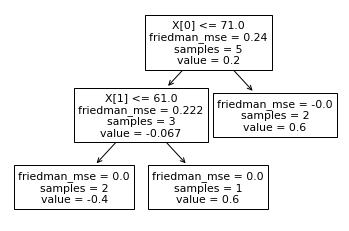

In [164]:
# build one weak tree model
from sklearn import tree

data = {'score1': [30, 90, 40, 65, 77], 'score2': [40, 35, 80, 42, 92], 'admission': [0, 1, 1, 0, 1]}
df = pd.DataFrame(data = data)

# load data
X = df.iloc[:,:2].values
# residuals of F_0 as y
y = np.array([-0.4, 0.6, 0.6, -0.4, 0.6])
# fit model no training data
model = tree.DecisionTreeRegressor(criterion="friedman_mse")
model.fit(X, y)
# plot single tree
tree.plot_tree(model)
plt.show()

In the Decision Tree above, we can see that multiple examples land on the same leaf nodes. These values are in terms of log odds, and we need to update the prediction values for these leaf nodes using the following formula:

$$
\text {Updated leaf values} = \frac {\sum {Residuals} } {\sum {(\text{Previous Prediction})} \cdot {(\text{1-Previous Prediction})}}
$$

Our previous prediction value is 0.4.

For first two leaves that correspond to the first and fourth sample, we get:
```
(-0.4 + -0.4) / (0.4 * 0.6 + 0.4 * 0.6) = -1.67  
```

And, for the last two leaves that correspond to the second and the fifth example:
```
0.6 + 0.6 / 0.4 * 0.6 + 0.4 * 0.6 = 2.5
```
Now, we add the log odds predictions of \\(f_1\\) to that of \\(F_0\\), and then apply the logistic function to convert the log odds to probability. The probabilities greater than or equal to 0.5 result in a predcition value of 1, and less than 0.5 are predicted as 0.

```
X[0]   X[1]    y        F_0      y-y^    f_1      F_0+f_1   logistic(F_0+f_1)   F_1
30     40      0        0.4     -0.4    -1.67     -2.07       0.112              0
90     35      1        0.4      0.6     2.5       3.1        0.957              1
40     80      1        0.4      0.6     0.6       1.2        0.769              1
65     42      0        0.4     -0.4    -1.67     -2.07       0.112              0
77     92      1        0.4      0.6     2.5       3.1        0.957              1
```

This example explained the steps that are followed in GBT modelling in a very simplified manner.

####3. Implement Final Model: GBT

In [167]:
# Load Full joined and featured engineered dataset
data = Datasets(DatasetRange.FULL, TEMP_DATA_FILEPATH)
data.LoadJoinedDataset("proposed_features")
df = data.Get(DataType.JOINED)

trainingData, valData, testData = splitDataset(df, train_split=0.6, val_split=0.2)

Full Dataset Max/Min Time
Min time: 2015-01-01 05:00:00
Max time: 2019-12-31 23:59:00

Training Dataset Max/Min Time
Min time: 2015-01-01 05:00:00
Max time: 2017-12-31 16:23:00

Validation Dataset Max/Min Time
Min time: 2017-12-31 16:24:00
Max time: 2018-12-31 20:11:00

Test Dataset Max/Min Time
Min time: 2018-12-31 20:13:00
Max time: 2019-12-31 23:59:00

In [168]:
data.SaveJoinedDataset(trainingData, "trainingData")
data.SaveJoinedDataset(valData, "valData")
data.SaveJoinedDataset(testData, "testData") 

In [169]:
# Specify hyperparameter tunings
depths = [2, 3, 5]
stepSizes = [0.1, 0.3, 0.5]

# Manual Grid Search 
models = []
parameters = []
val_auroc_scores = []
val_aupr_scores = []

tail_num_count = trainingData.select('TAIL_NUM_MOD').distinct().count()
fl_num_count = trainingData.select('OP_CARRIER_FL_NUM_MOD').distinct().count()
if (tail_num_count > fl_num_count):
  max_bins = tail_num_count+1
else:
  max_bins = fl_num_count+1
  
string_indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid = 'keep') for c in categoricals]
# Establish features columns
featureCols = list(map(lambda c: c+"_idx", categoricals)) + numericals

# Build the stage for the feature transformation pipeline
feature_transform_stages = string_indexers + \
                     [VectorAssembler(inputCols=featureCols, outputCol="features"), \
                      StringIndexer(inputCol=outcome, outputCol="label")]

# hyper parameter tuning loop
for depth in depths:
  for stepsize in stepSizes:
    # Define a GBT model.
    gbt = GBTClassifier(featuresCol="features",
                        labelCol="label",
                        lossType = "logistic",
                        maxBins = max_bins+1,
                        maxDepth = depth,
                        stepSize = stepsize,
                        maxIter = 20)

    gbt_pipeline = Pipeline(stages=feature_transform_stages+[gbt])
    gbt_model = gbt_pipeline.fit(trainingData)

    #predictions_training = gbt_model.transform(trainingData)
    predictions_val = gbt_model.transform(valData)

    val_auroc, val_aupr = get_AUROC_AUPR(predictions_val, "Final GBT Val", verbose=True)

    models.append(gbt_model)
    parameters.append({"depth": depth, "stepSize": stepsize})
    val_auroc_scores.append(val_auroc)
    val_aupr_scores.append(val_aupr)

Final GBT Val Scores: Area Under ROC: 0.7312842413836158, Area Under PR: 0.7279357916657756
Final GBT Val Scores: Area Under ROC: 0.7374512405197388, Area Under PR: 0.7332305174814027
Final GBT Val Scores: Area Under ROC: 0.7363327254822736, Area Under PR: 0.7317073342459629
Final GBT Val Scores: Area Under ROC: 0.7363842044913136, Area Under PR: 0.7330936363122301
Final GBT Val Scores: Area Under ROC: 0.7409630737189773, Area Under PR: 0.739061275226818
Final GBT Val Scores: Area Under ROC: 0.7391748096361538, Area Under PR: 0.7359513990373981
Final GBT Val Scores: Area Under ROC: 0.7400332530759567, Area Under PR: 0.7393635240914548
Final GBT Val Scores: Area Under ROC: 0.7407466680990734, Area Under PR: 0.7399965168714383
Final GBT Val Scores: Area Under ROC: 0.7360770037500013, Area Under PR: 0.734378733084694

In [170]:
params_scores = list(zip(parameters, val_auroc_scores))  
params_scores

Out[185]: [({'depth': 2, 'stepSize': 0.1}, 0.7312842413836158),
 ({'depth': 2, 'stepSize': 0.3}, 0.7374512405197388),
 ({'depth': 2, 'stepSize': 0.5}, 0.7363327254822736),
 ({'depth': 3, 'stepSize': 0.1}, 0.7363842044913136),
 ({'depth': 3, 'stepSize': 0.3}, 0.7409630737189773),
 ({'depth': 3, 'stepSize': 0.5}, 0.7391748096361538),
 ({'depth': 5, 'stepSize': 0.1}, 0.7400332530759567),
 ({'depth': 5, 'stepSize': 0.3}, 0.7407466680990734),
 ({'depth': 5, 'stepSize': 0.5}, 0.7360770037500013)]

In [171]:
# Best model parameters
best_model_index = np.argmax(val_auroc_scores)
best_gbt_final_model = models[best_model_index]

print("Best GBT Final Model Parameters: ", parameters[best_model_index])
print("Best GBT Final Val Score: ", val_auroc_scores[best_model_index])

Best GBT Final Model Parameters: {'depth': 3, 'stepSize': 0.3}
Best GBT Final Val Score: 0.7409630737189773

In [172]:
# save off the best final model
best_gbt_final_model.write().overwrite().save("{}/gbt_model_final".format(TEMP_MODELS_FILEPATH))

In [173]:
# make predictions with testData
predictions_test = best_gbt_final_model.transform(testData)

In [174]:
# save predictions for later use
predictions_test.write.mode('overwrite').save("/final_project_team11/dataframes/predictions_test")

In [175]:
def evaluate(predictionAndLabels, model_name):
  
    # print Area Under Receiver Operating Characteristic curve
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')    
    print("{}: Area Under ROC = {}".format(model_name, evaluator.evaluate(predictionAndLabels)))

    # Print Area Under Precision Recall curve
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    print("{}: Area Under PR = {}".format(model_name, evaluator.evaluate(predictionAndLabels)))

    # Metrics
    predictionRDD = predictionAndLabels.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)
    
    # Overall accuracy
    accuracy = metrics.accuracy
    print("Overall Accuracy = %s" % accuracy)

    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        label_precision = metrics.precision(label)
        label_recall = metrics.recall(label)
        label_fmeasure = metrics.fMeasure(label, beta=1.0)
        print("[Class %s]\tPrecision = %s | Recall = %s | F1-Measure = %s" \
                  % (label, label_precision, label_recall, label_fmeasure))
        
def plot_roc_pr(predictions):
    bcm = BinaryClassificationMetrics(predictions, scoreCol='probability', labelCol='label')
    # PLOT both ROC and PR curves
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    bcm.plot_roc_curve(ax=axs[0])
    bcm.plot_pr_curve(ax=axs[1])
    
def plot_confusion_matrix(predictions):
    predictionRDD = predictions.select(['label', 'prediction']) \
                        .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    confusion_matrix = metrics.confusionMatrix().toArray()
    print(confusion_matrix)
    df_cm = pd.DataFrame(confusion_matrix)
    ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.15g', cbar=False)
    for t in ax.texts:
      t.set_text('{:,d}'.format(int(t.get_text())))

    plt.title('Confusion Matrix', fontsize = 15) 
    plt.xlabel('Predicted', fontsize = 15) 
    plt.ylabel('Actual', fontsize = 15)    

In [176]:
# Evaluate testdata predictions
print("====================== Detailed Test Evaluation Metrics =======================")
evaluate(predictions_test, "GBT Final Model")

====================== Detailed Test Evaluation Metrics =======================
GBT Final Model: Area Under ROC = 0.7323721026413814
GBT Final Model: Area Under PR = 0.7360264168258421
Overall Accuracy = 0.6732608559819797
[Class 0.0]	Precision = 0.6564757202741646 | Recall = 0.7673104793313104 | F1-Measure = 0.707579129131207
[Class 1.0]	Precision = 0.6986674549598084 | Recall = 0.5733180816957785 | F1-Measure = 0.6298164145388196

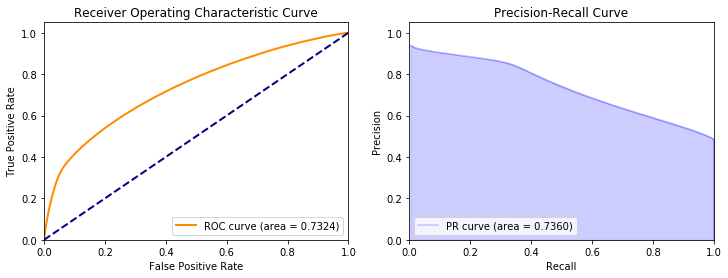

In [177]:
# Plot ROC and PR
plot_roc_pr(predictions_test)

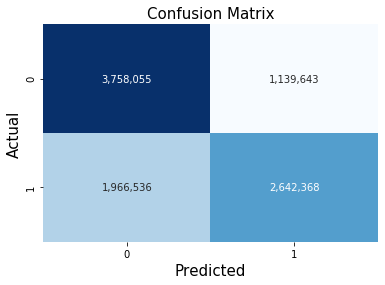

In [178]:
# Plot Confusion Matrix
plot_confusion_matrix(predictions_test)

We have got Test AUC score of 0.7324 with our model. We also note that there are large number of False Positives and False Negatives.

In [180]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))
  
featureImportances = best_gbt_final_model.stages[-1].featureImportances
featuresList = ExtractFeatureImp(featureImportances, predictions_test, "features")
featuresList[['idx', 'name', 'score']].head(15)

,idx,name,score
24,6,TAIL_NUM_PREV_DEP_DEL15_idx,0.238939
8,15,CRS_DEP_TIME_MINS_sin,0.158175
19,1,ORIGIN_AIRPORT_ID_idx,0.116859
11,18,DAY_OF_YEAR_cos,0.083230
20,2,DEST_AIRPORT_ID_idx,0.062672
23,5,OP_CARRIER_FL_NUM_MOD_idx,0.055988
10,17,DAY_OF_YEAR_sin,0.040646
21,3,OP_CARRIER_AIRLINE_ID_idx,0.040263
22,4,TAIL_NUM_MOD_idx,0.038437
2,9,CIG_HEIGHT_DIM,0.038279


Here, we can see the list of top most important 15 features for the GBT model. TAIL_NUM_PREV_DEP_DEL15, CRS_DEP_TIME_MINS, ORIGIN_AIRPORT_ID, DAY_OF_YEAR, and DEST_AIRPORT_ID are the top 5 predictors of flights delays.

In [182]:
# ratio of non-delayed flights predicted as delayed
predictions_test.filter((f.col('label') == 0) & (f.col('prediction') == 1)).count()/predictions_test.filter(f.col('label') == 0).count()

Out[169]: 0.23268952066868967

The above shows that **0.23 fraction** of the non-delayed flights were predicted as delayed.

In [184]:
# show 10 records of False Positives
display(predictions_test.filter((f.col('label') == 0) & (f.col('prediction') == 1))\
        .select('label', 'rawPrediction', 'probability', 'prediction').limit(10))

label,rawPrediction,probability,prediction
0.0,"List(1, 2, List(), List(-0.08258669965703136, 0.08258669965703136))","List(1, 2, List(), List(0.45880027604476087, 0.5411997239552391))",1.0
0.0,"List(1, 2, List(), List(-0.0836431357839407, 0.0836431357839407))","List(1, 2, List(), List(0.4582756902673439, 0.5417243097326561))",1.0
0.0,"List(1, 2, List(), List(-0.02671605803996347, 0.02671605803996347))","List(1, 2, List(), List(0.48664514816069027, 0.5133548518393097))",1.0
0.0,"List(1, 2, List(), List(-0.10125860339774664, 0.10125860339774664))","List(1, 2, List(), List(0.44954303076478175, 0.5504569692352183))",1.0
0.0,"List(1, 2, List(), List(-0.40845888609907116, 0.40845888609907116))","List(1, 2, List(), List(0.30641832272023256, 0.6935816772797674))",1.0
0.0,"List(1, 2, List(), List(-0.6876025385449853, 0.6876025385449853))","List(1, 2, List(), List(0.2017801895101347, 0.7982198104898652))",1.0
0.0,"List(1, 2, List(), List(-0.7300328987255398, 0.7300328987255398))","List(1, 2, List(), List(0.1884572618715236, 0.8115427381284764))",1.0
0.0,"List(1, 2, List(), List(-0.5480363677153834, 0.5480363677153834))","List(1, 2, List(), List(0.2504764684801944, 0.7495235315198057))",1.0
0.0,"List(1, 2, List(), List(-0.06569159008654943, 0.06569159008654943))","List(1, 2, List(), List(0.4672013709597826, 0.5327986290402174))",1.0
0.0,"List(1, 2, List(), List(-0.6064786242474379, 0.6064786242474379))","List(1, 2, List(), List(0.2291782182079818, 0.7708217817920182))",1.0


The above shows that for some of the wrong predicted delays, the delay probability is very close to 0.5. We can reduce the number of such false positive predictions by increasing the probability threshold, say to 0.8.

##Results

#### Algorithmic Exploration - 6 month dataset (Jan 2015 - Jun 2015)
We used the 6 months of airlines data to explore various models. Below, we present the results of the explored models.

```
Model 	                       Training AUROC   Training AUPR   Test AUROC 	Test AUPR
Baseline Logistic Regression 	  0.717400 	     0.697340 	   0.635499 	0.662183
Tuned Logistic Regression 	     0.707674 	     0.686826 	   0.653153 	0.679220
Random Forest 	                 0.741560 	     0.722997 	   0.632865 	0.664410
GBT 	                           0.739886 	     0.715002 	   0.641360 	0.674551
```

Our decision to use the GBT model is articulated above.

#### Final GBT model - Full 5 year data set (Jan 2015 - Dec 2019)
For tuning hyperparameters of the final GBT model, we used cross-validation with different values for maxDepth and stepSize parameters. We got the following best parameters and corresponding validation AUC score.
```
Best GBT Final Model Parameters:  {'depth': 3, 'stepSize': 0.3}
Best GBT Final Val Score:  0.7409630737189773
```

Detailed test evaluation metrics with the best GBT model was:
```
====================== Detailed Test Evaluation Metrics =======================
GBT Final Model: Area Under ROC = 0.732372525051765
GBT Final Model: Area Under PR = 0.7360256794092914
Overall Accuracy = 0.6732608559819797
[Class 0.0]	Precision = 0.6564757202741646 | Recall = 0.7673104793313104 | F1-Measure = 0.707579129131207
[Class 1.0]	Precision = 0.6986674549598084 | Recall = 0.5733180816957785 | F1-Measure = 0.6298164145388196
```

As noted from the Confusion Matrix, with this model, there were 1,139,643 False Positives, and 1,966,536 False Negatives. These are substantially large number of false predictions. In the flight delay prediction case, False Positives (predicting non-delays as delays) can have extremely disastrous effects. False Positives can be controlled by calibrating the probability threshold of the model.

#### Challenges and Learnings

The biggest challenge in this project was to handle and process massive datasets. Particularly, joining airlines and weather datasets was an interesting task and presented quite a challenge. Furthermore, we were new to Spark DataFrame and MLlib APIs, and learned them as the work on the project progressed.

Throughout this project, we learned  a number of new concepts, algorithms, implementation techniques, and APIs. Some of the notable things we learned include: Spark DataFrames, how to build the complete data pipelines, MLlib APIs, various feature engineering techniques, oversampling, handling parquet files, importance of cross-validation, and features reduction and selection.

Since we were dealing with large datasets, scalability was our main concern from the beginning. All the steps of data processing, including joining and transforming of datasets, and feature engineering took long CPU cycles. In order to optimize data processing, we ensured to cache DataFrames after a sequence of transformations and an action. In addition, we stored intermediate joined, transformed and feature engineered datasets and models on to disk so that those could be accessed later on without requiring to process everything all over again. For instance, we saved pageranks, joined full and 6 months datasets, intermediate feature engineered datasets, and built models on to the disk. 

Another scalability hurdle we bumped into was the long CPU times required for training of models. In the first attempt, our final GBT model took approximately two hours to train. Cross-validation added on to the training time dramatically. To circumvent that, we attempted to reduce the number of features to train on by selecting only the most important ones. This helped with the training times substantially.

It is important to realize that the flights data changes frequently, which essentially means that our trained models become stale very quickly. This emphasizes the importance of training time even more. In this case, one of the factors that makes GBT training computationally expensive is the large number of values for categorical variables. In order to reduce the categorical variables values, we combined the values having frequency less than the 80th percentile into a single value. 

For future work, reducing training time would be one of the goals. An approach that could be tried for treating categorical values is to 'bucketize or binning' the levels. Along with optimizing the training time, reducing 'False Positives' for the model would be another equally important goal. Predicting non-delaying flights as 'delayed' could be disastrous for airlines and customers alike, and we would like to avoid that.

## Conclusions

In this project, we built a flight delay prediction classifier system. We implemented a Gradient Bossting Trees model, and achieved a test **AUROC score of 0.7324** with it. Before implementing our model, we first explored a few algorithms using a smaller six month dataset. These models included Logistic Regression, Random Forests and Gradient Boosting Trees(GBT). 

Before algorithm exploration and model building, we performed a number of data pre-processing and feature engineering steps to extract meaningful features. The data pre-processing steps included handling missing values, transforming certain variables to different units, and joining airlines, weather and stations datasets. In addition, we engineered a few new features in order to add more predictive power to our model. Some of the engineered features were: PageRanks for origin and destination airports, a binary variable indicating whether the previous flight of a TAIL_NUM was delayed or not, and cyclical features for time period variables. During our EDA, we had noticed the class imbalance in the dataset. We took care of it by oversampling records for the minority class. This helped our baseline model score immensely. There were a number of categorical variables in the dataset, and some of them (TAIL_NUM, for example) had a large number of values. For these categorical variables, we combined the levels that occured less than 80th percentile into a single level.

For our data-pipeline, we standarized, one-hot-encoded, and label encoded our features. For regression models, one-hot-encoding for categorical variables increased the dimentionality of our features. This was handled by selecting the most important and relevant features using L1 regularization.

For future work, the current model can be futher improved by attempting to reduce the number of False Positives. One approach to achieve that could be to calibrate the threshold for the model so as not to predict wrong flight delays. Reducing the training time of the model is another important goal for the future.

## Applications of Course Concepts

This section list some of the important concepts that we leared during this course, and were able to apply them in this project.  

* **Data at Scale**: In this course, we learned how to deal with large scale data that can not fit into a single machine. With this project, we got an opportunity to apply the learned techniques to handle lage Airlines and Weather datasets. Specifically, we used the **Spark** framework and **DataFrames** to work on the large scale data. 

* **Embarrasingly Parallel**: We used Spark **DataFrames**, which are distributed collection of data organized into named coulumns, to read large datasets into from the parquet files. Spark DataFrames enable mapping, transformation and processing of data in an embarrasingly parallel way leveraging the underlying **Functional Programming Paradigm**.

* **Bias Variance Trade-off**: In order to make our models generalizable and to avoid them overfitting the training data, we used a combination of L1 and L2 regularization for regression models. For decision tree based models, we reduced the number of features by combining the low frequency levels for the categorical variables.

* **Standarization of Variables**: In order for machine learning models to converge, it is important that features are standardized before they are fed into training models. This important concept was emphasized in one of the homework assignments where the Gradient Descent algorithm failed to converge when the input variables were not standarized. We applied this concept to standardize the features for our Baseline Logistic Regression model.

* **Multicollinearity**: We noticed multicollinearity in some of the features of interest. To handle that we used L1 (lasso) regularization to remove one of the two correlated features.

* **Algorithms Explored and Implemented**: Throughout the course, we learned a number of machine learning algorithms including supervised and unsupervised models, and implemented them at scale. In this project, we explored Logistic Regression, Random Forests, and Gradient Boosting Trees, and finally implemented and tuned a Gradient Boosting Model.

## References

1. 
**Prediction of weather-induced airline delays based on machine learning algorithms**    
Authors:  Sun Choi ; Young Jin Kim ; Simon Briceno ; Dimitri Mavris   
https://ieeexplore.ieee.org/document/7777956  

2.  
**Predicting flight delays**   
Author: Fabien Daniel  
https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial  

3.   
**A Data Mining Approach to Flight Arrival Delay Prediction for American Airlines**     
Authors: Navoneel Chakrabarty  
https://arxiv.org/ftp/arxiv/papers/1903/1903.06740.pdf  

4.  
**Gradient boosting**  
Authors: Terence Parr and Jeremy Howard  
https://explained.ai/gradient-boosting/

5.    
**Gradient Boosting In Classification: Not a Black Box Anymore!**  
Author: Vihar Kurama  
http://zpz.github.io/blog/gradient-boosting-tree-for-binary-classification/